<a href="https://colab.research.google.com/github/YashJoshi2109/Early_Sepsis_Prediction/blob/main/Early_sepsis_prediction_Synthetic_Dataset_(6hours_early).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# importing all the required libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Importing and splitting the data into training and testing

In [15]:
combined = pd.read_csv('Dataset.csv')

In [16]:
patients = list(combined['Patient_ID'].unique())
len(patients)

14058

In [17]:
# importing the file with the combined data of both the hospitals and splitting it into 2 parts

#  = pd.read_csv('/kaggle/input/prediction-of-sepsis/Dataset.csv')
#sepsis-physionet

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [21]:
# importing the test and training data

df_train = pd.read_csv('data_part1.csv')
df_test = pd.read_csv('data_part2.csv')

In [22]:
# Training data first five columns
df_train.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,1.0,0.0,17072.0
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,2.0,0.0,17072.0
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,3.0,0.0,17072.0
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,4.0,0.0,17072.0
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0.0,NaN,NaN,-0.02,5.0,0.0,17072.0


In [23]:
# Testing data first five columns
df_test.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,58.18,0.0,1.0,0.0,-2.43,1.0,0.0,9891.0
1,1,1,119.0,98.0,NaN,137.0,87.00,NaN,NaN,NaN,...,NaN,NaN,58.18,0.0,1.0,0.0,-2.43,2.0,0.0,9891.0
2,2,2,120.0,97.0,NaN,151.0,95.00,NaN,NaN,NaN,...,NaN,NaN,58.18,0.0,1.0,0.0,-2.43,3.0,0.0,9891.0
3,3,3,116.0,97.0,36.0,153.0,84.33,NaN,NaN,NaN,...,NaN,NaN,58.18,0.0,1.0,0.0,-2.43,4.0,0.0,9891.0
4,4,4,147.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,58.18,0.0,1.0,0.0,-2.43,5.0,0.0,9891.0


# Exploratory data analysis

In [24]:
df_train.head(15)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,1.0,0.0,17072.0
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,2.0,0.0,17072.0
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,3.0,0.0,17072.0
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,4.0,0.0,17072.0
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0.0,NaN,NaN,-0.02,5.0,0.0,17072.0
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,6.0,0.0,17072.0
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,7.0,0.0,17072.0
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,8.0,0.0,17072.0
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,9.0,0.0,17072.0
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,10.0,0.0,17072.0


As can be seen, this is a time series data. The dataframe has 44 columns. After the first loook at data, it can be observed that the data seems quite sparse.

In [25]:
# let's list down all the different columns

df_train.columns

Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
       'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
       'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

In [26]:
# list of all the unique patients
# total number of patients present in the dataset

patients = list(df_test['Patient_ID'].unique())
len(patients)

6236

In [27]:
# Function to draw correlation heat map

def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [31]:
# Percentage of null values present in all the parameters

null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

EtCO2               100.000000
TroponinI            99.861334
Bilirubin_direct     99.844865
Fibrinogen           99.184143
Bilirubin_total      98.729937
Alkalinephos         98.483566
AST                  98.442065
Lactate              96.596916
SaO2                 95.161179
PTT                  95.110785
Calcium              94.971789
Phosphate            94.902950
Platelets            93.446791
Creatinine           93.330193
WBC                  92.473494
Magnesium            92.214936
HCO3                 91.921794
BUN                  91.825617
Chloride             91.670482
PaCO2                91.370752
Hgb                  91.203101
BaseExcess           89.753201
Potassium            89.236085
pH                   88.725886
Hct                  88.321086
Glucose              87.907064
FiO2                 85.982207
Temp                 66.399325
Unit2                49.760381
Unit1                49.760381
Unit                 49.760381
DBP                  48.036442
SBP     

Image obtained from the official pdf of the PhysioNet Challenge. The image gives an overall idea of the number of records available for each feature, for all the three datasets of three different hospitals.

After thorough analysis of the data, it was found that a lot of the features were redundant, i.e. a lot of the features were indicative of the same parameter, so those features were removed on the basis of their sparsity. Another criteria taken into consideration was ease of getting the parameter among different hospitals, becuase some of the parameters are easier to obtain for a given hospital while some are expensive and for some a hospital does not even have infrastructure to get those features.

In [32]:
# the features have been removed based on the number of null values and redundancy

# 'Unnamed: 0'-- this is the index column
# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.

columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

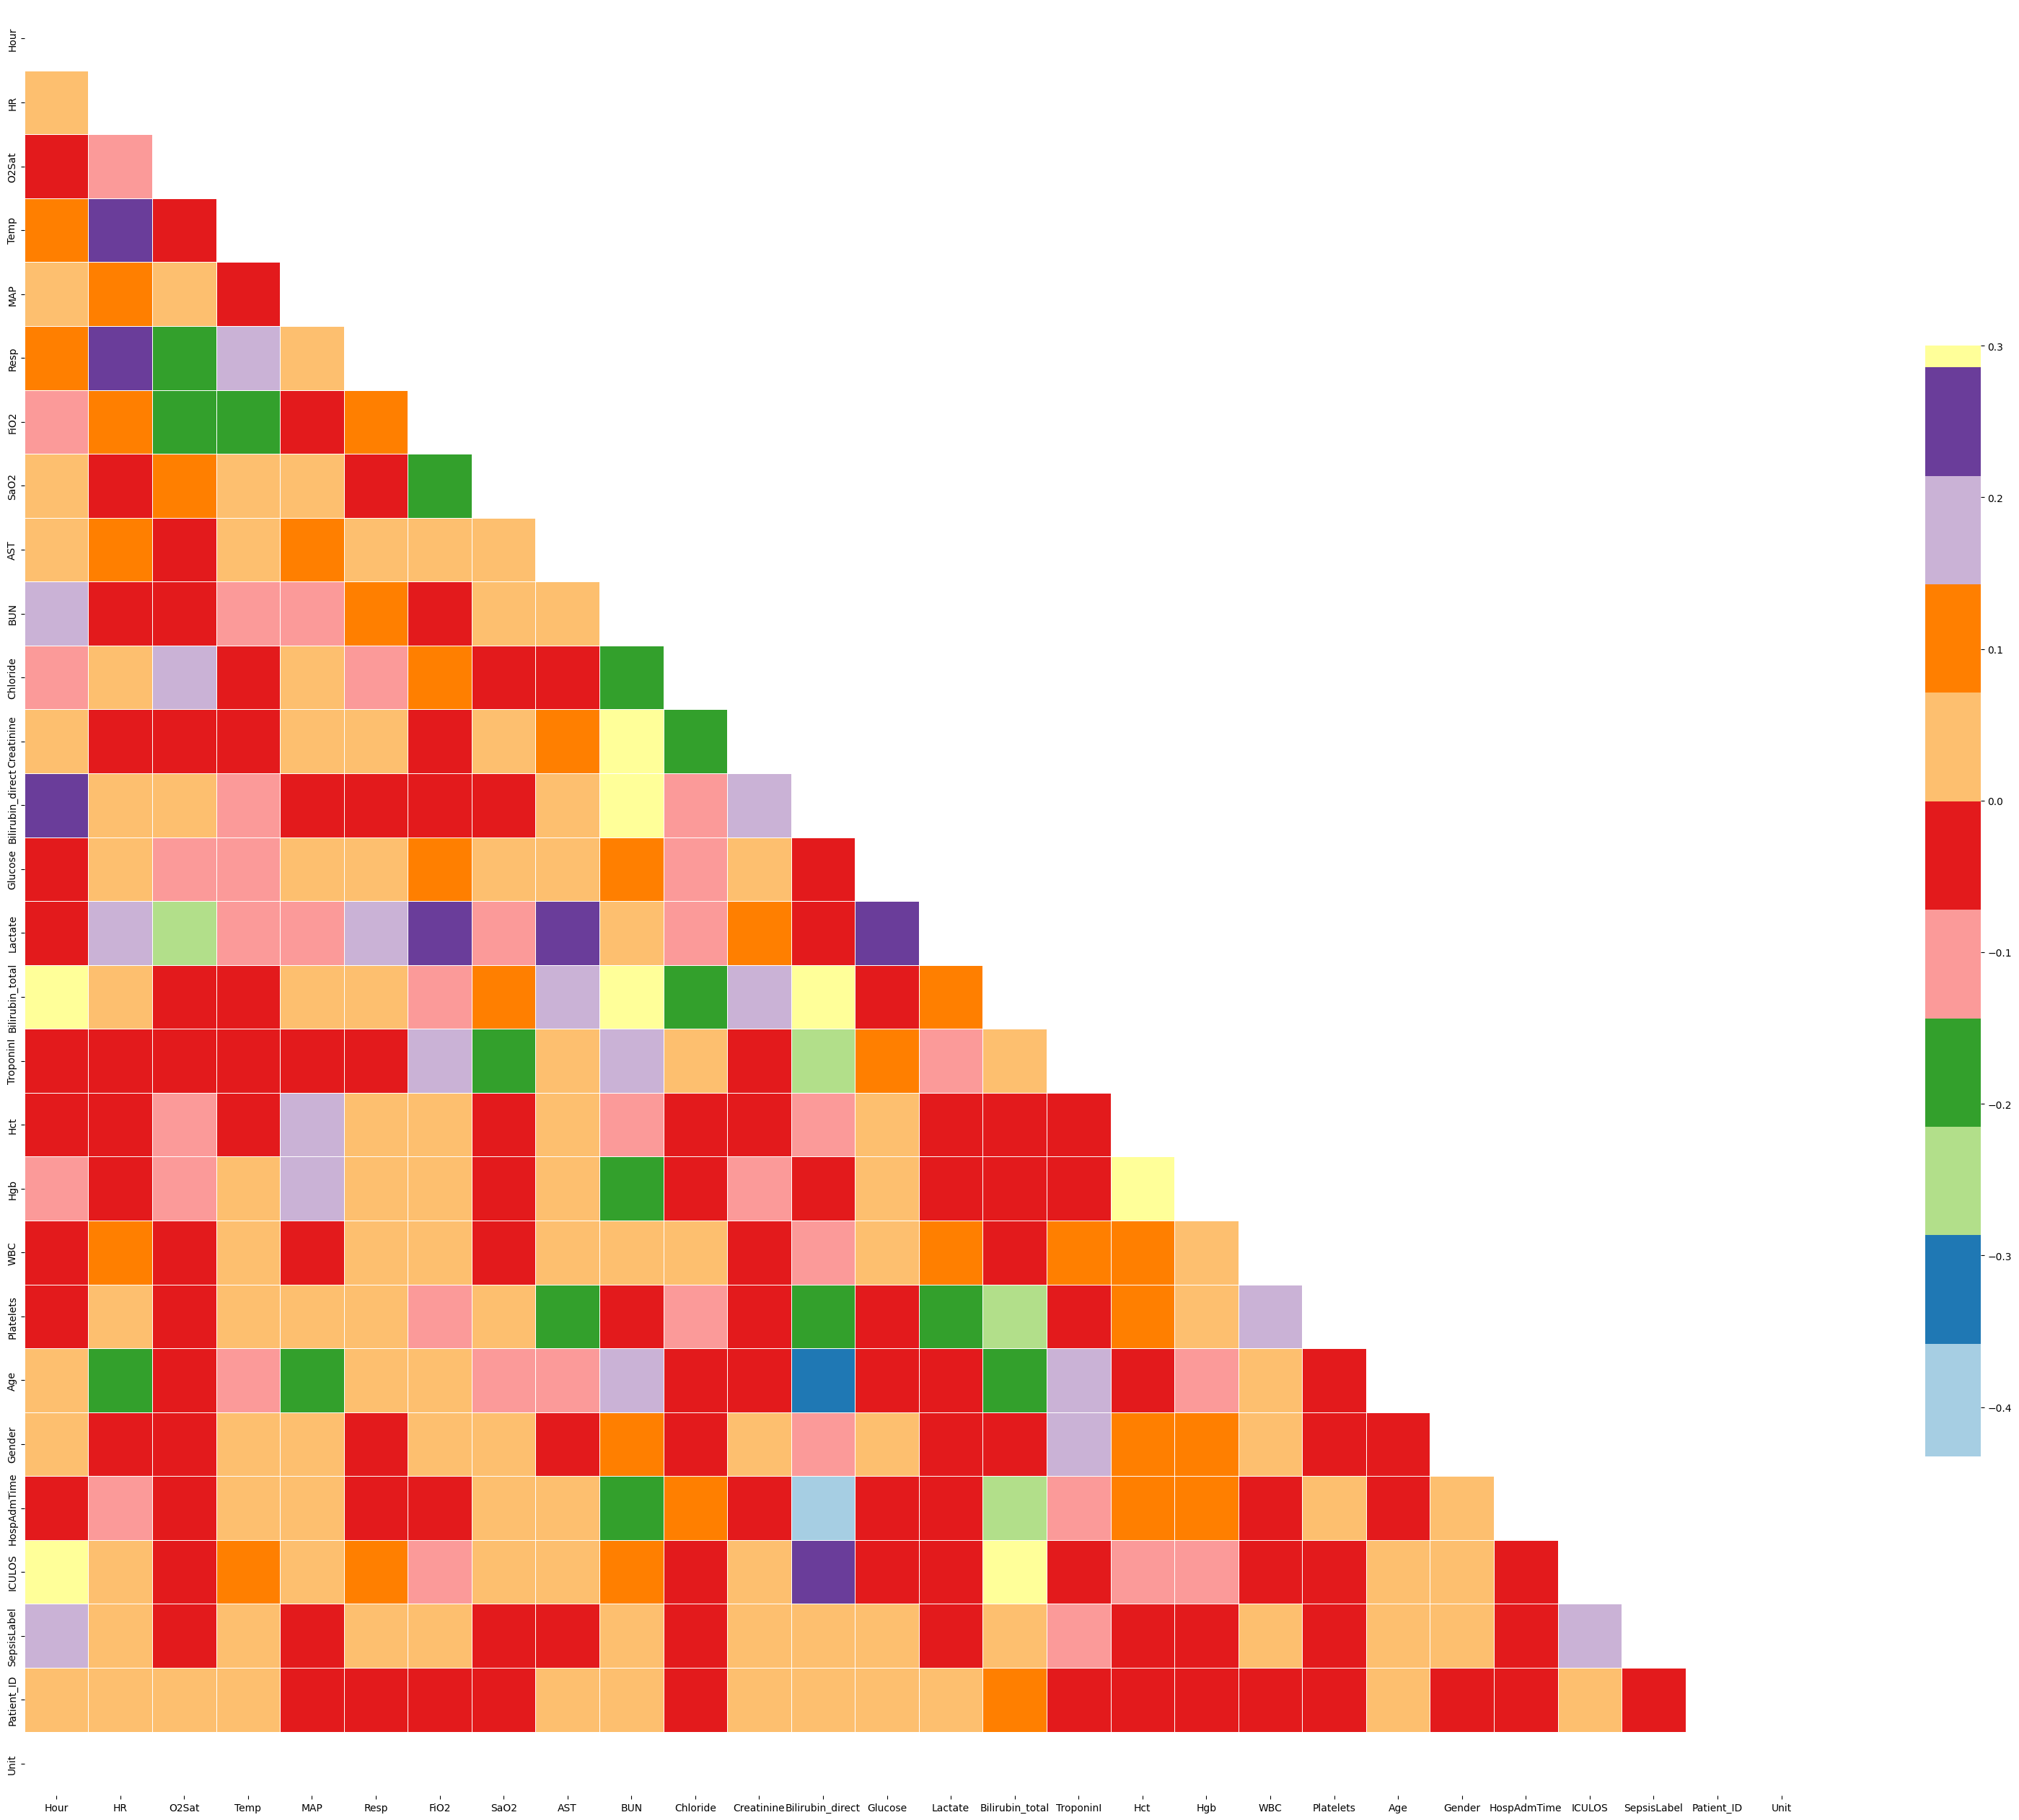

In [33]:
# correlation matrix to check if there is high correlation between the remaining features

corr_matrix(df_train_mod)

As can be seen in this correlation heat map almost all of the feature do not have high correlation.

# Imputation

Since there are a lot of missing values in the dataset, therefore imputation was done to fill the missing values. While imputing, it is important to note that ***imputation should be done on per patient basis,*** otherwise the data from one patient will leak into the data of the other patient. Also another point that should be taken into consideration is that mean, median, mode can not directly be used to impute as it will result in uneven distribution of the parameters with respect to time.

In [34]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [35]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

/var/folders/nh/kck6hr314vv_9n1v0l6b_2j80000gn/T/ipykernel_84145/468124072.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [36]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp  FiO2  SaO2   AST  \
Patient_ID                                                                   
1.0        72964     0   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           72965     1   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           72966     2   89.0   99.0  36.11  86.00  22.0  0.28  88.0  16.0   
           72967     3   90.0   95.0  36.11  91.33  30.0  0.28  88.0  16.0   
           72968     4  103.0   88.5  36.11  91.33  24.5  0.28  88.0  16.0   

                   BUN  ...   Hgb  WBC  Platelets    Age  Gender  HospAdmTime  \
Patient_ID              ...                                                     
1.0        72964  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   
           72965  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   
           72966  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   
           72967  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   
           72968  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   

                  ICULOS  SepsisLabel  Patient_ID  Unit  
Patient_ID                                               
1.0        72964     1.0          0.0         1.0   NaN  
           72965     2.0          0.0         1.0   NaN  
           72966     3.0          0.0         1.0   NaN  
           72967     4.0          0.0         1.0   NaN  
           72968     5.0          0.0         1.0   NaN  

[5 rows x 28 columns]

In [37]:
# Now let's check the remaining proportion of missing values

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

TroponinI           97.088661
Bilirubin_direct    95.942109
Bilirubin_total     66.792158
AST                 66.173593
SaO2                57.892795
Lactate             56.383932
Unit                49.760216
FiO2                36.286503
WBC                  1.535213
Chloride             1.379749
Platelets            1.369538
Hgb                  1.192005
Creatinine           1.044446
BUN                  0.965067
Glucose              0.940693
Hct                  0.833317
Temp                 0.808943
Resp                 0.113634
O2Sat                0.027338
MAP                  0.007905
HR                   0.002964
Age                  0.000000
Gender               0.000000
HospAdmTime          0.000000
ICULOS               0.000000
SepsisLabel          0.000000
Patient_ID           0.000000
Hour                 0.000000
dtype: float64

'TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2', 'Unit', 'Patient_ID'  have more than 25 percent of null values and hence are dropped from the dataset.

In [38]:
# dropping all the columns with null values more than 25% and patient_id

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [39]:
# Now let's check the remaining proportion of missing values

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

WBC            1.535213
Chloride       1.379749
Platelets      1.369538
Hgb            1.192005
Creatinine     1.044446
BUN            0.965067
Glucose        0.940693
Hct            0.833317
Temp           0.808943
Resp           0.113634
O2Sat          0.027338
MAP            0.007905
HR             0.002964
HospAdmTime    0.000000
ICULOS         0.000000
Hour           0.000000
Gender         0.000000
Age            0.000000
SepsisLabel    0.000000
dtype: float64

In [40]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)


## Gaussian Transformation and Standard Normalization

Generally models tend to give a better result for a normal ditribution. So in the below cells we explored different techniques to plot histograms and QQ plots of all the features and then we applied different transformations on it to see which were giving good results. The ones giving the beest results were then adopted in the dataframe.

In [41]:
# function to draw histogram and QQ plot

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [42]:
def try_gaussian(df, col):
  print('actual plot')
  diagnostic_plots(df,col)
  # this applies yeojohnson plot
  df['col_yj'], param = stats.yeojohnson(df[col])
  print('yeojohnson plot')
  diagnostic_plots(df, 'col_yj')
  # this applies exponential transformation
  df['col_1.5'] = df[col]**(1/1.5)
  print('**1/1.5 plot')
  diagnostic_plots(df, 'col_1.5')
  df['col_.5'] = df[col]**(.5)
  print('**.5 plot')
  # this applies inverse transformation
  diagnostic_plots(df, 'col_.5')
  df['col_rec'] = 1 / (df[col]+0.00001)
  diagnostic_plots(df, 'col_rec')
  # this applies logarithmic trasnformation
  df['col_log'] = np.log(df[col]+1)
  diagnostic_plots(df, 'col_log')


/var/folders/nh/kck6hr314vv_9n1v0l6b_2j80000gn/T/ipykernel_84145/348954185.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_impute[col].fillna(df_train_impute[col].mean(), inplace=True)


O2Sat
actual plot


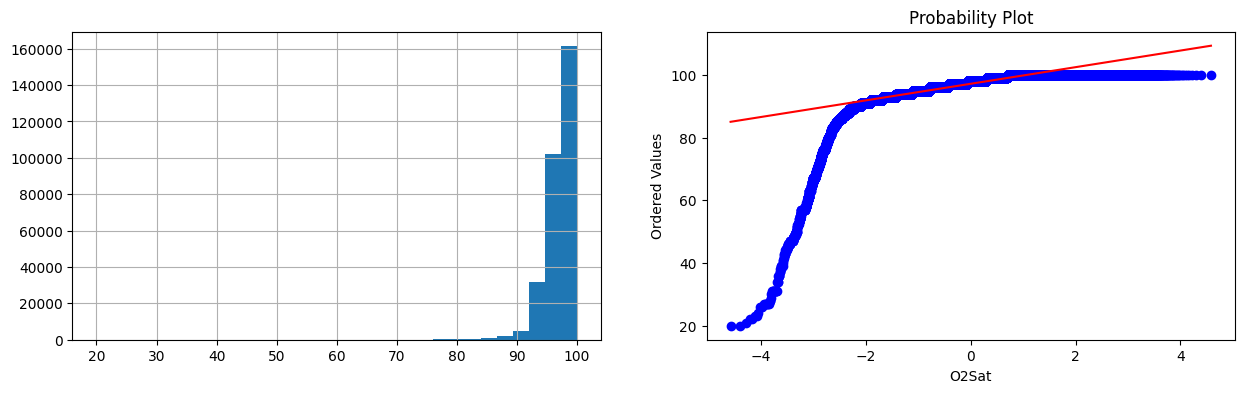

yeojohnson plot


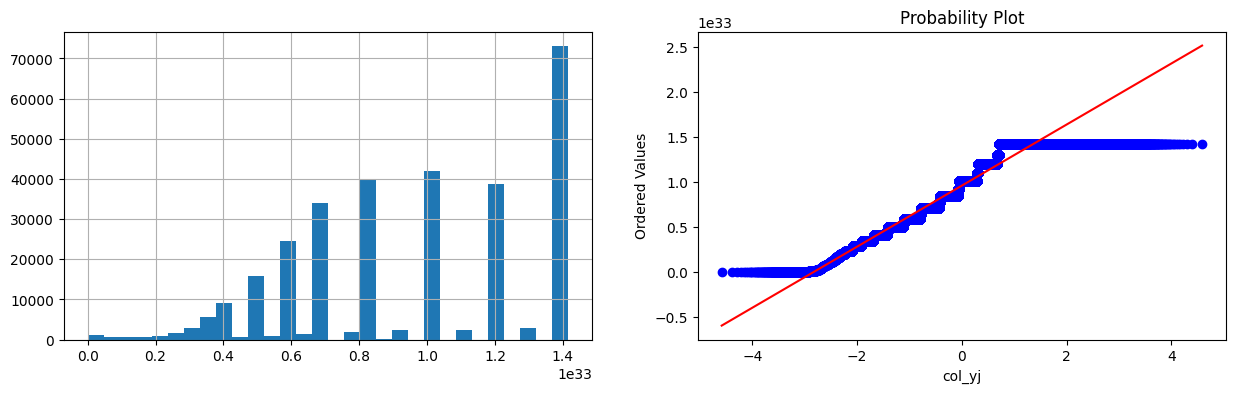

**1/1.5 plot


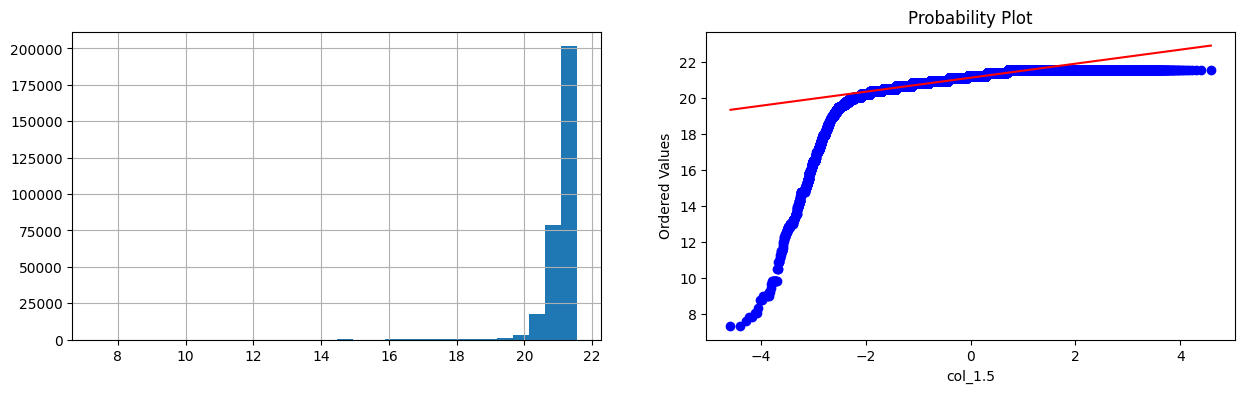

**.5 plot


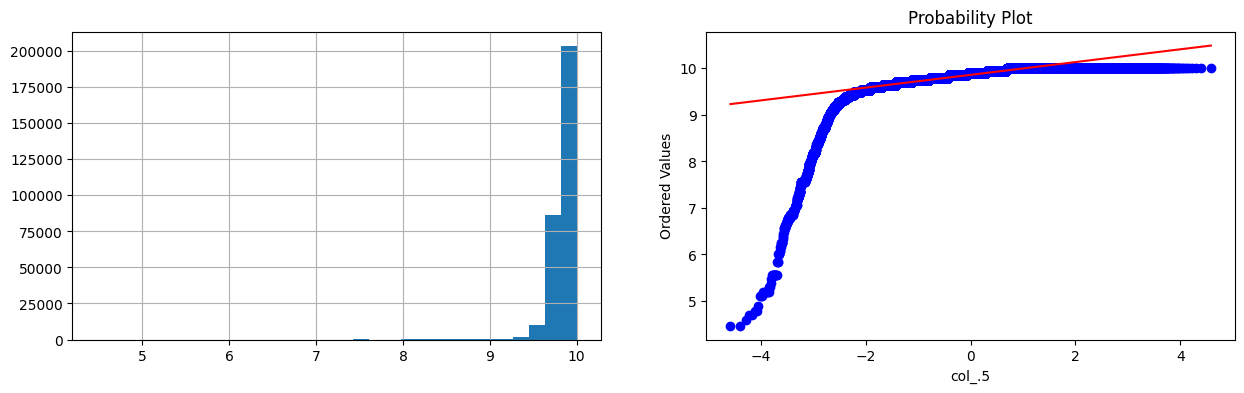

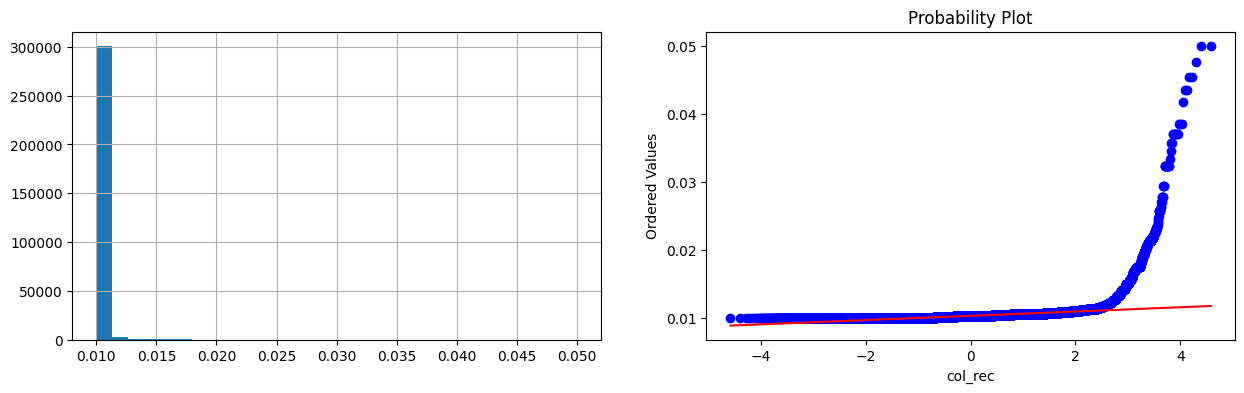

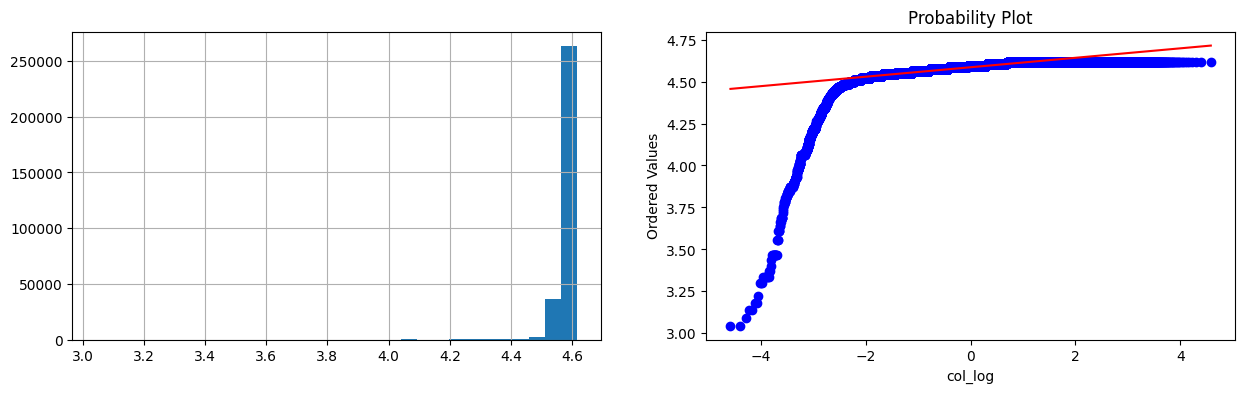

Temp
actual plot


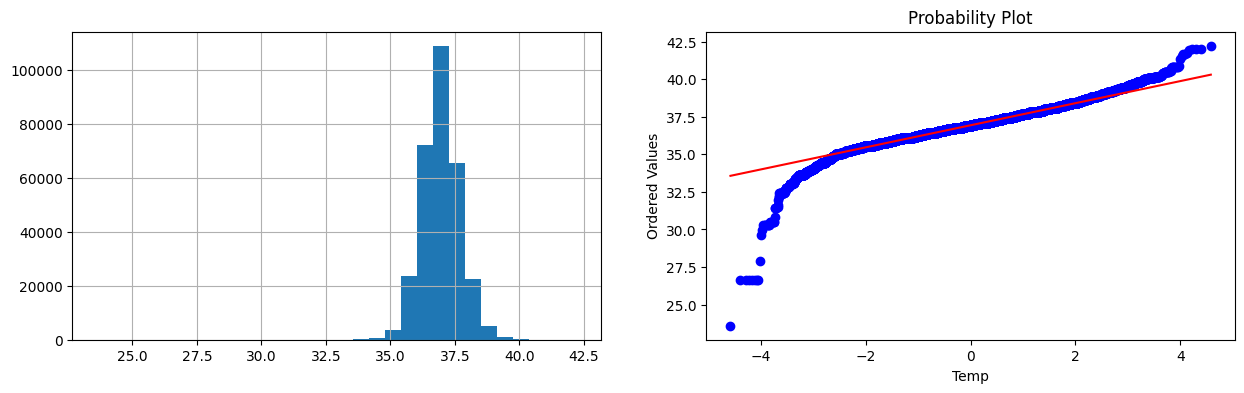

yeojohnson plot


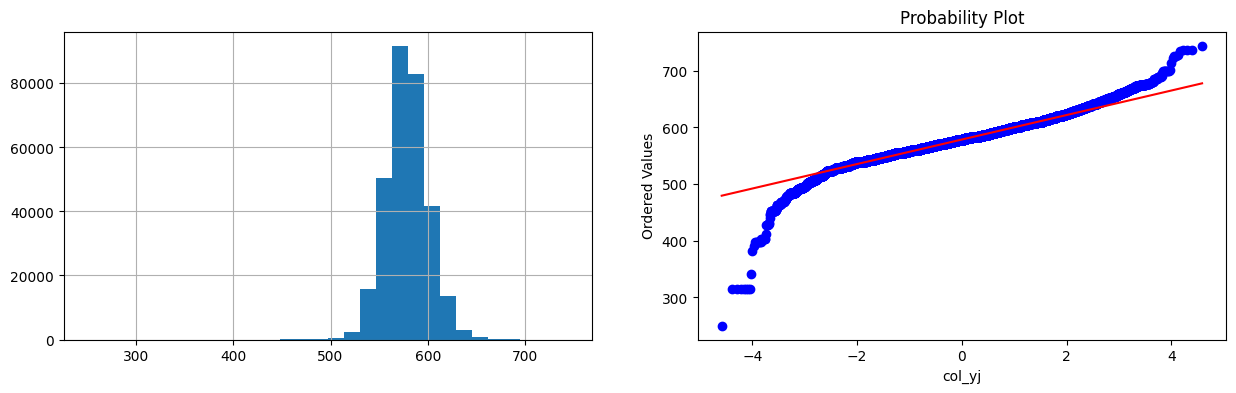

**1/1.5 plot


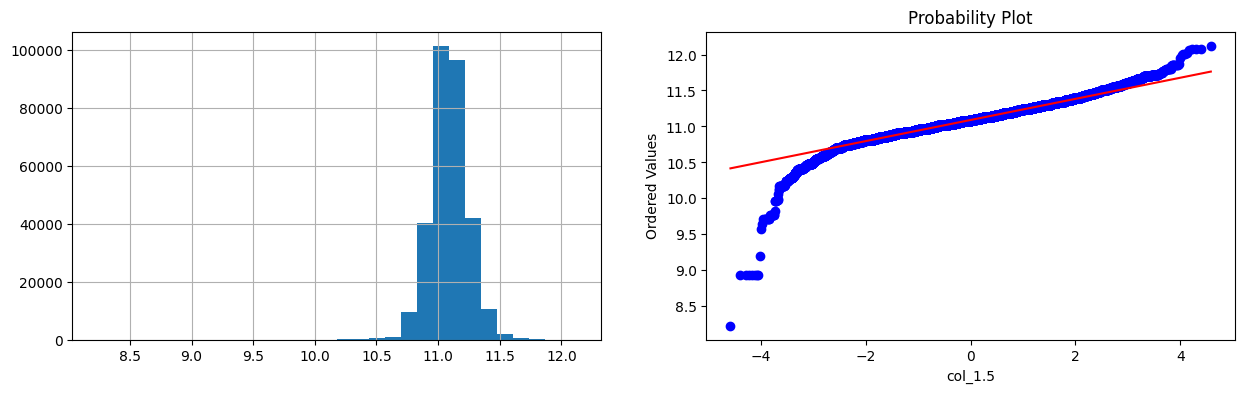

**.5 plot


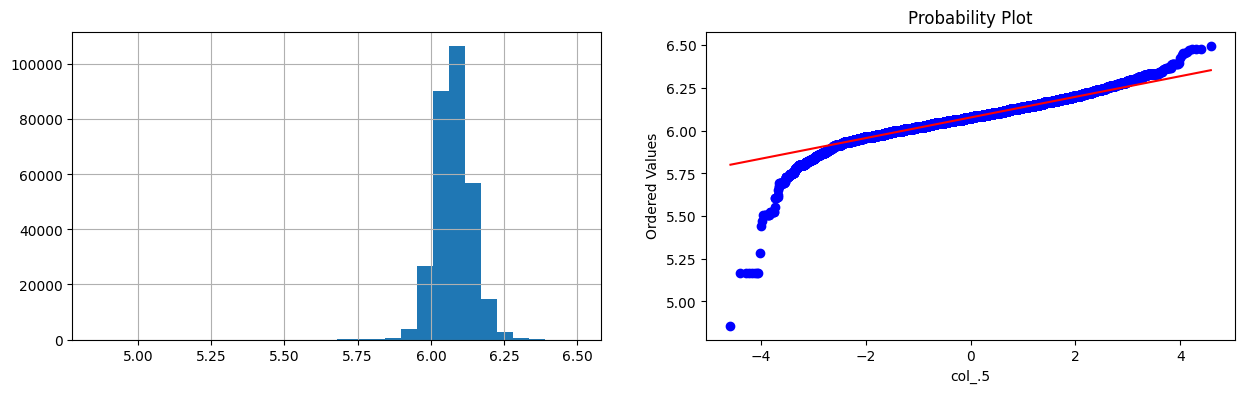

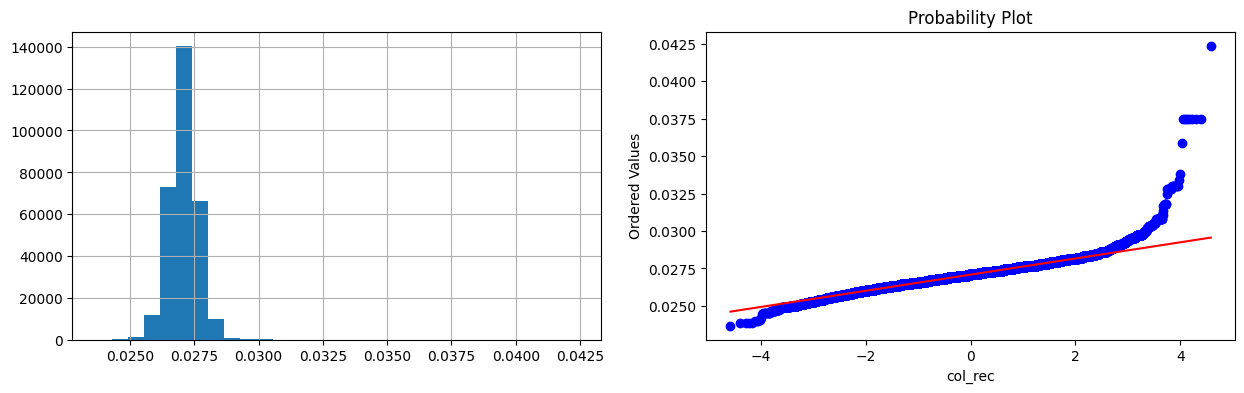

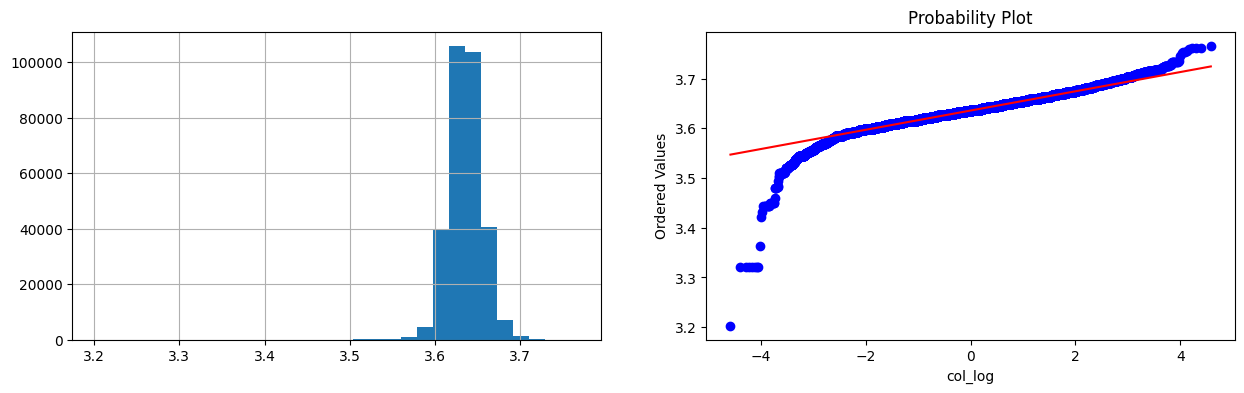

MAP
actual plot


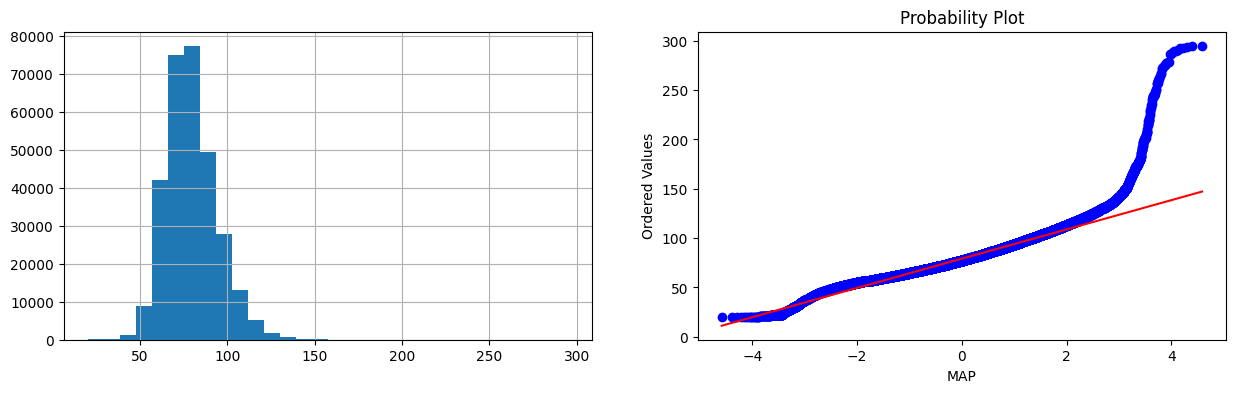

yeojohnson plot


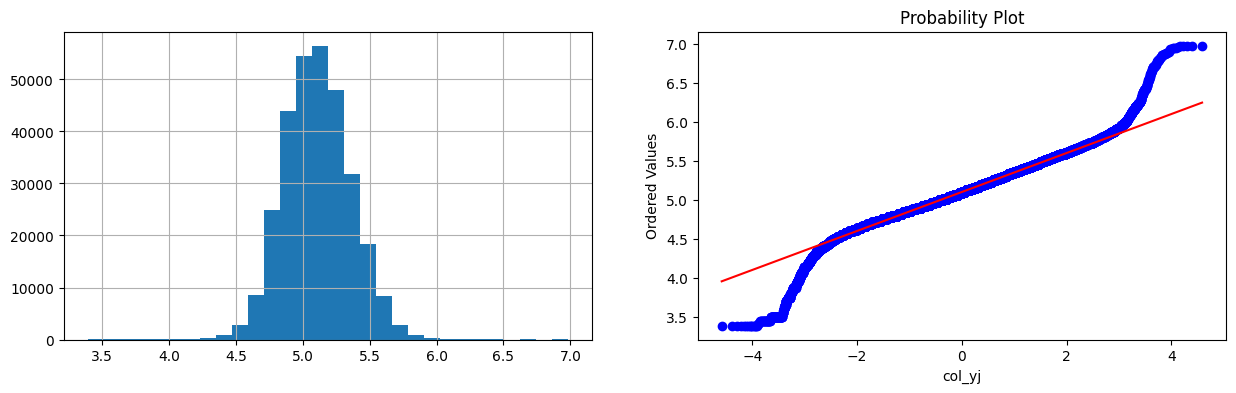

**1/1.5 plot


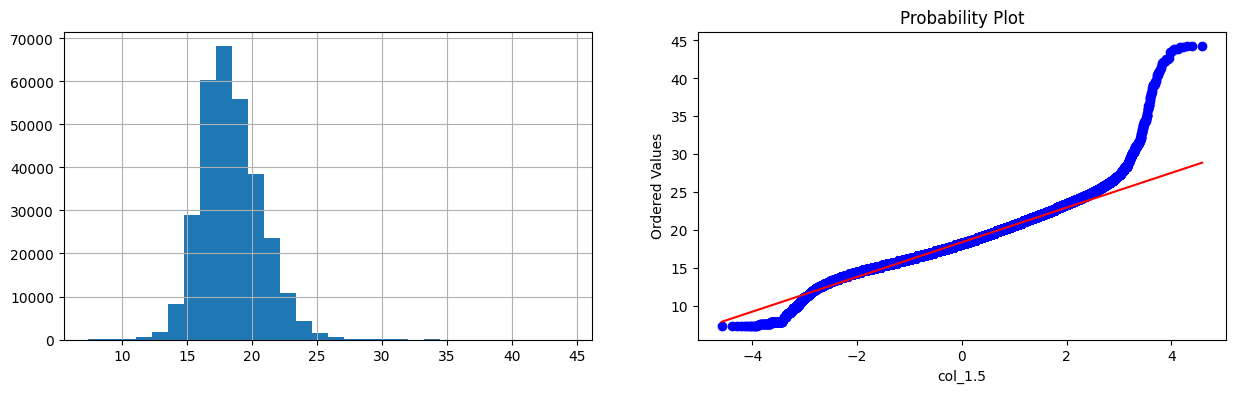

**.5 plot


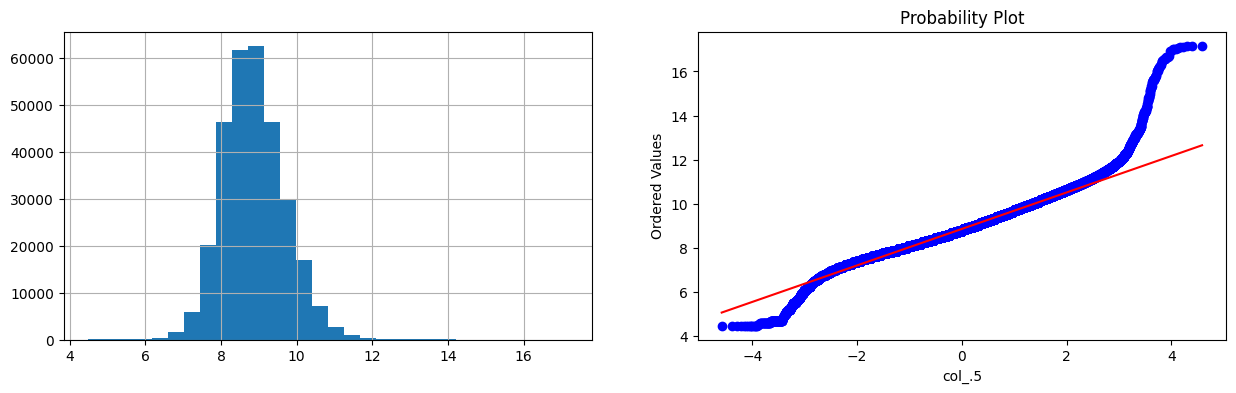

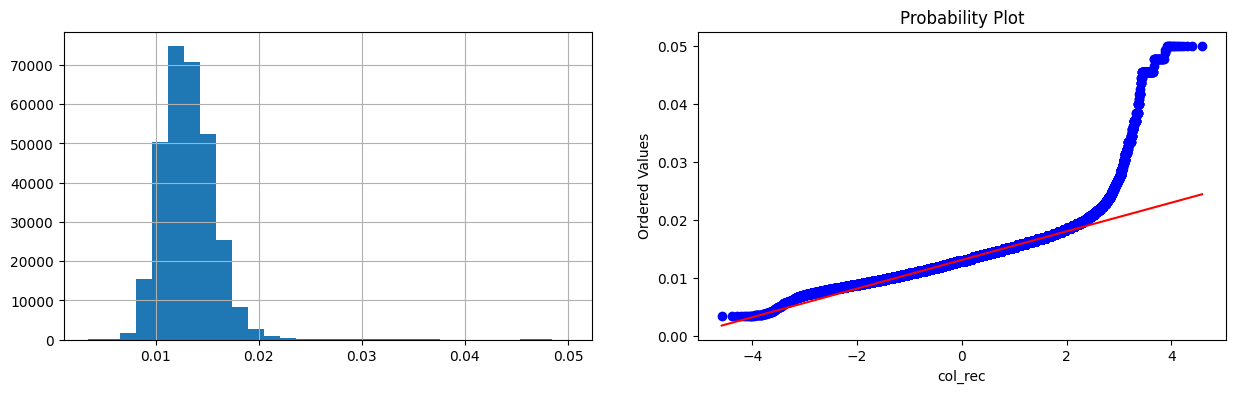

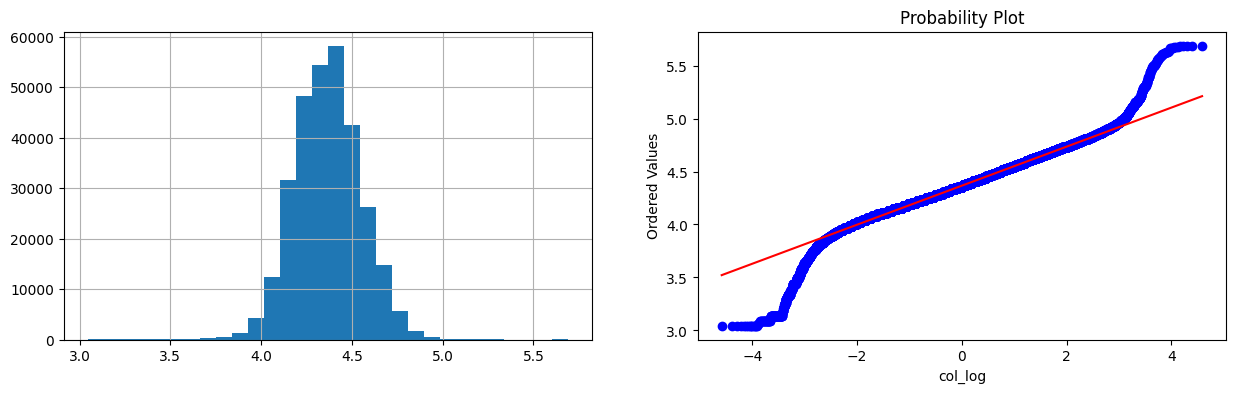

BUN
actual plot


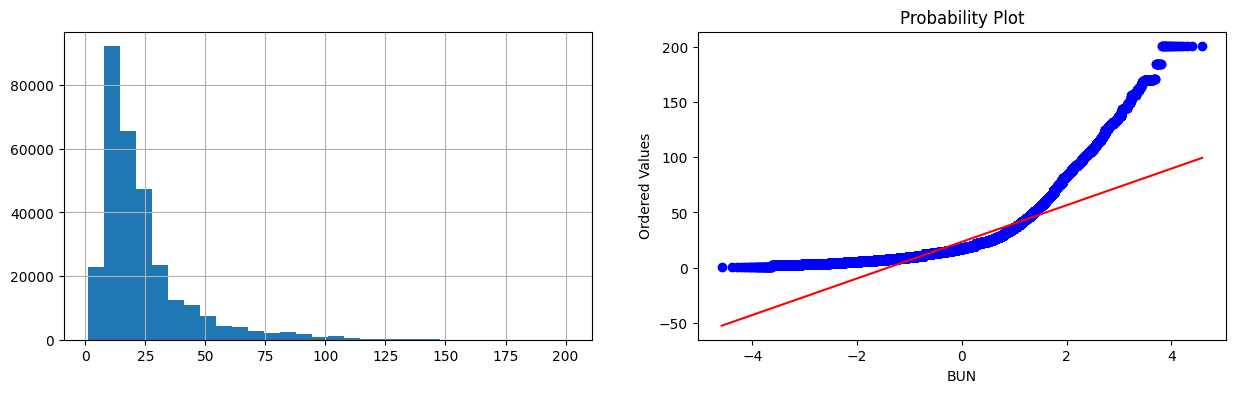

yeojohnson plot


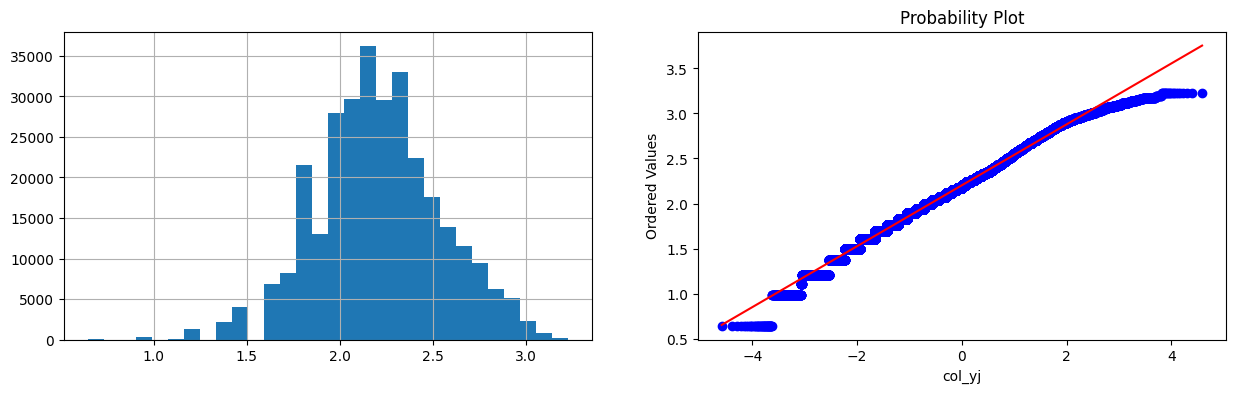

**1/1.5 plot


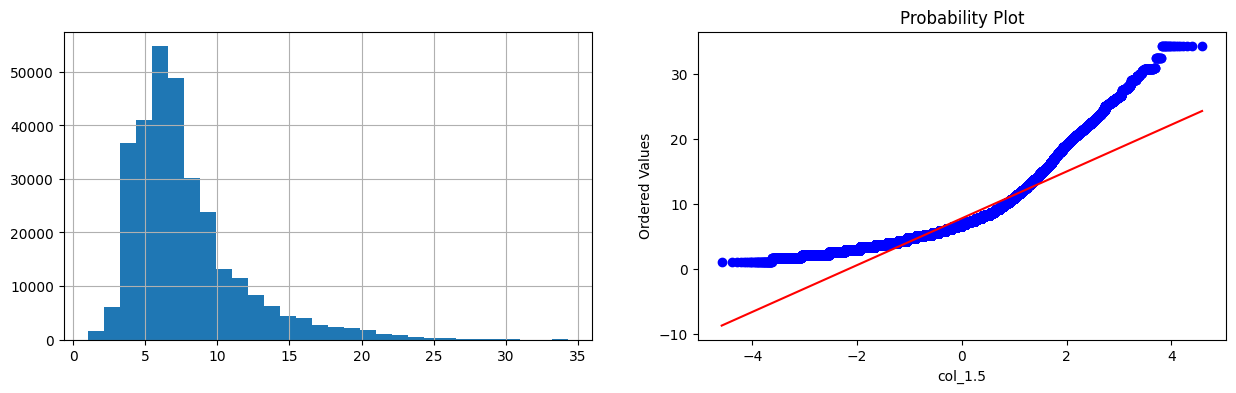

**.5 plot


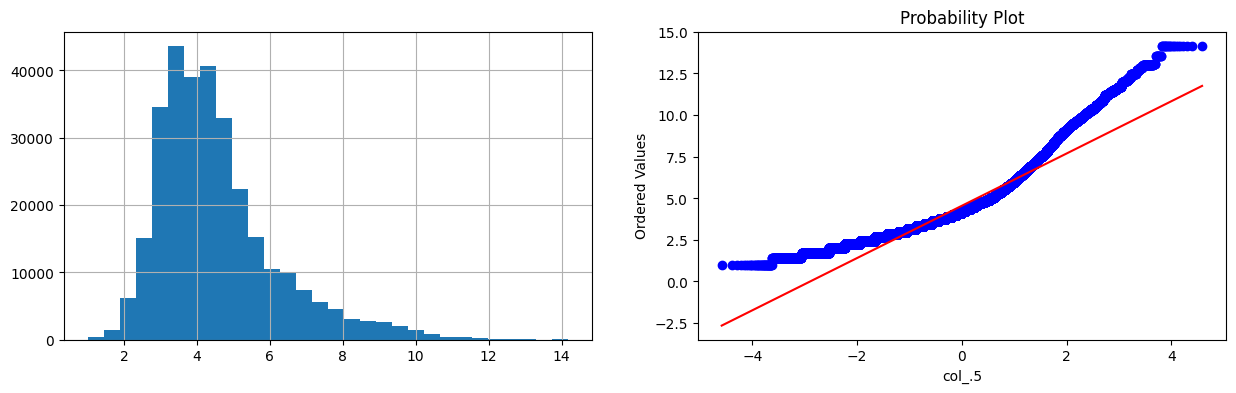

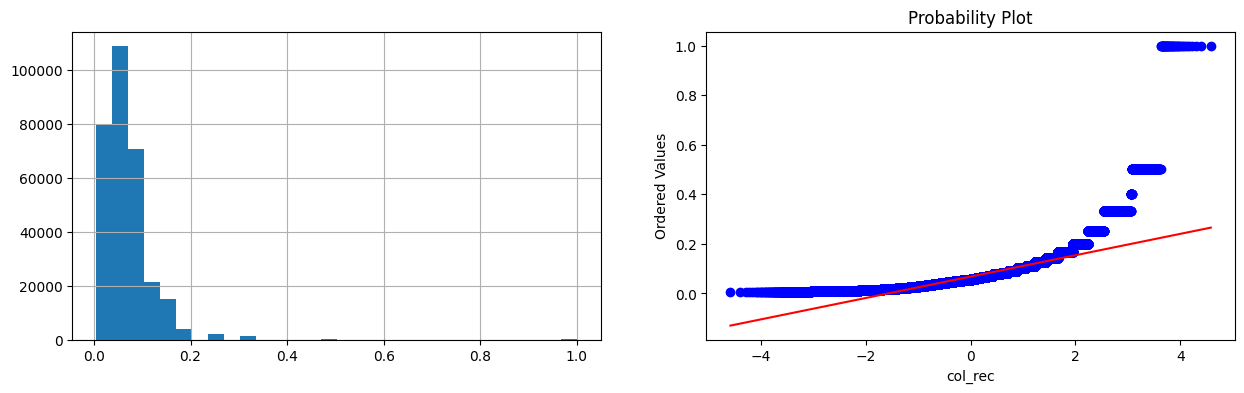

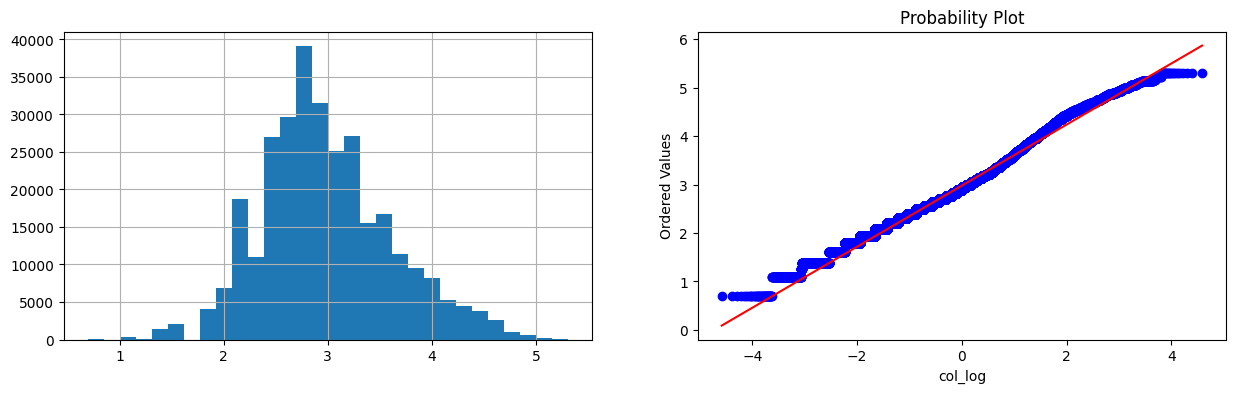

Creatinine
actual plot


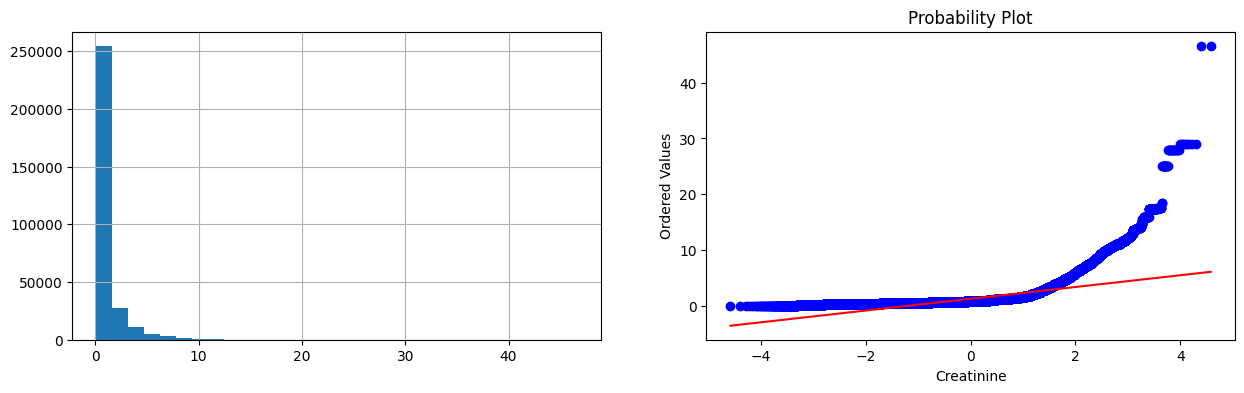

yeojohnson plot


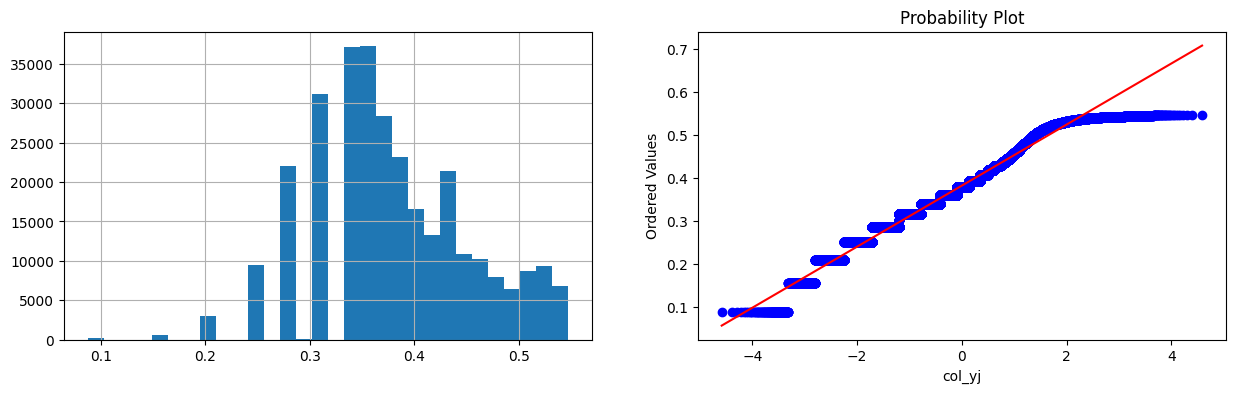

**1/1.5 plot


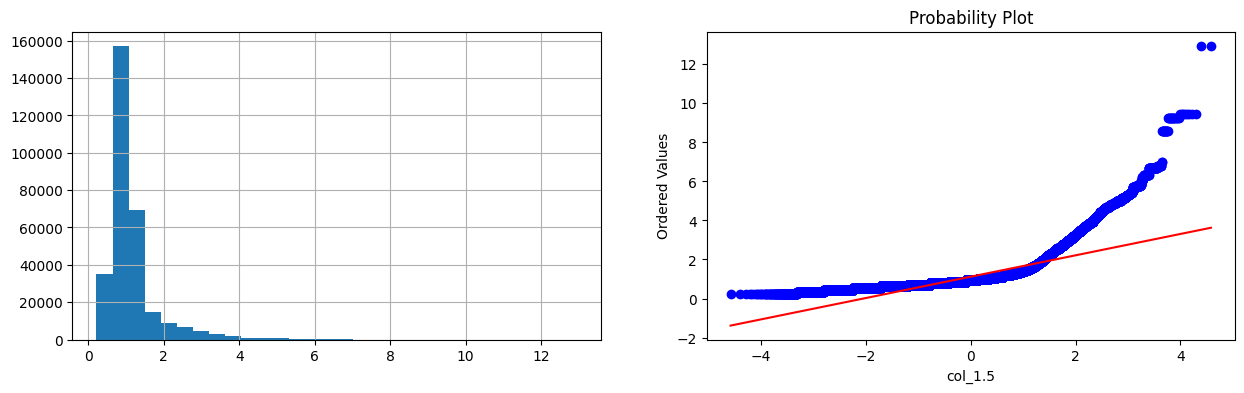

**.5 plot


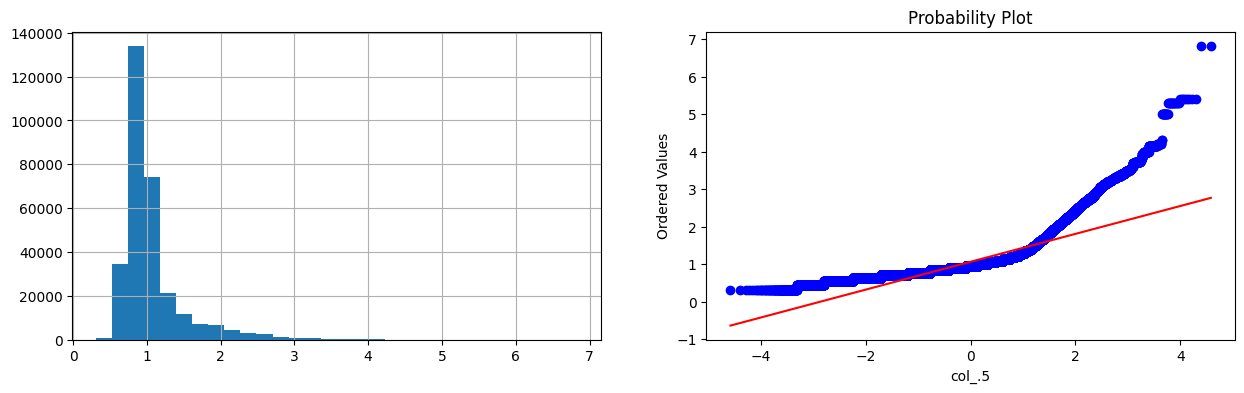

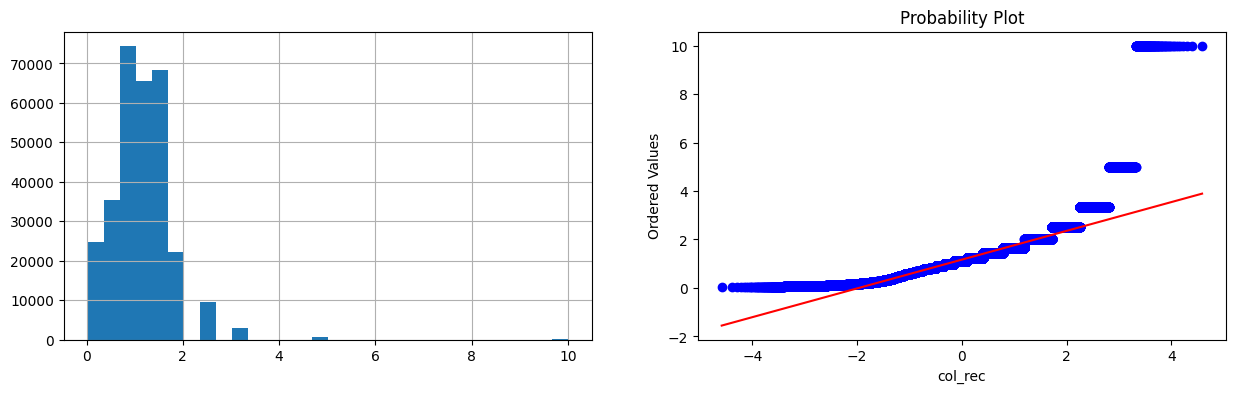

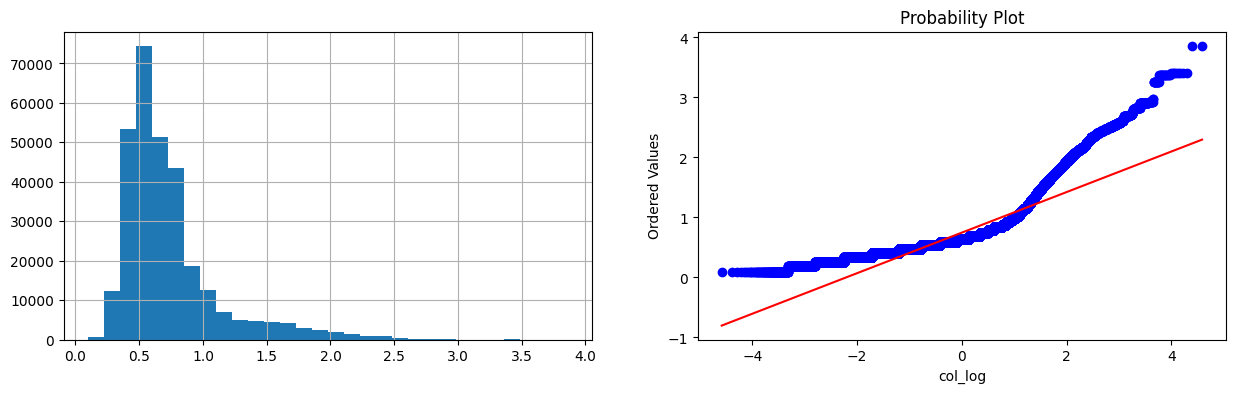

Glucose
actual plot


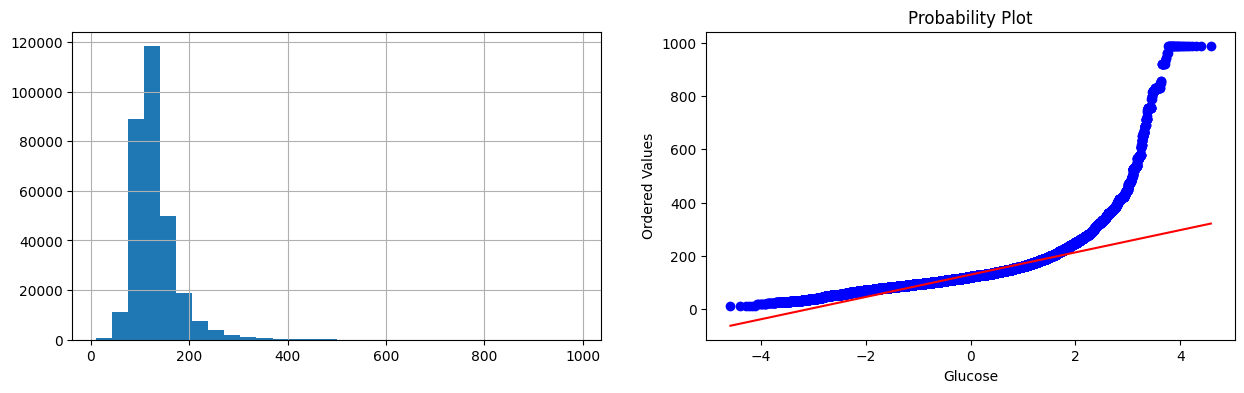

yeojohnson plot


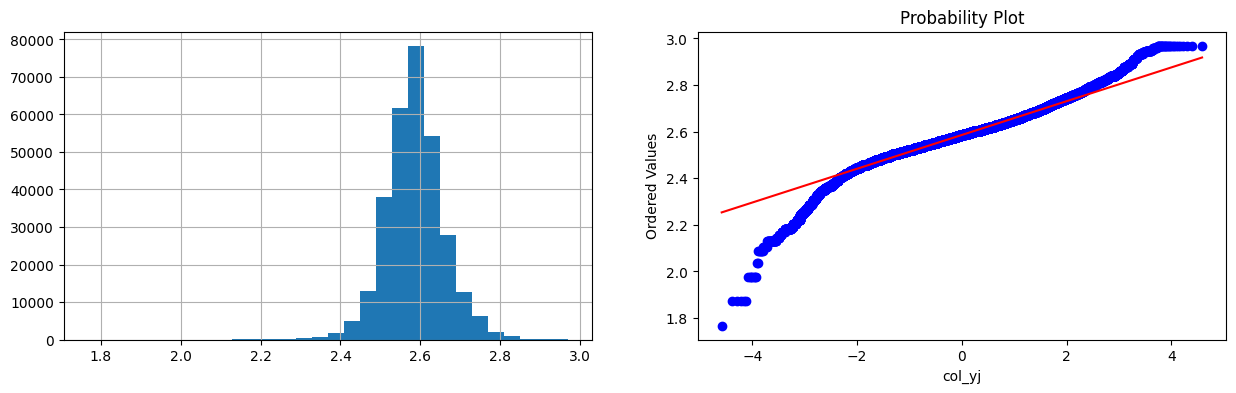

**1/1.5 plot


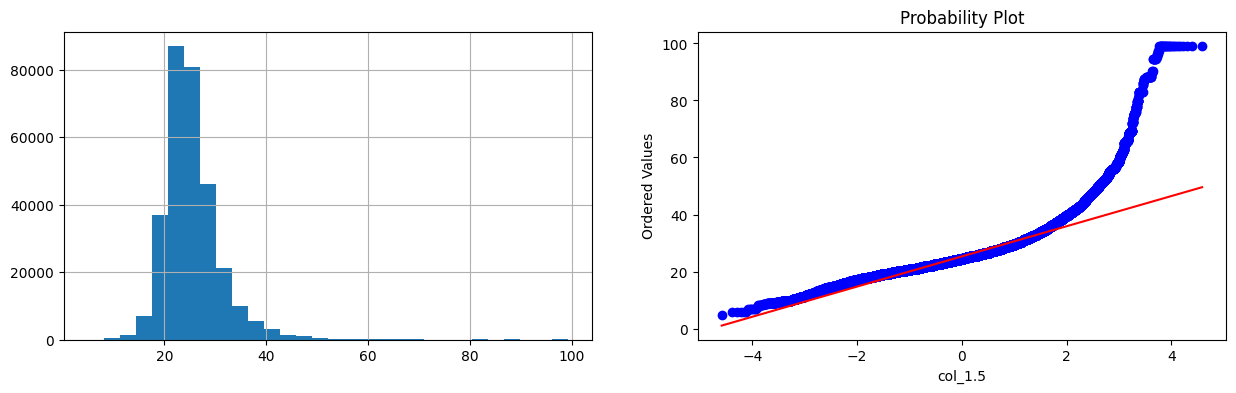

**.5 plot


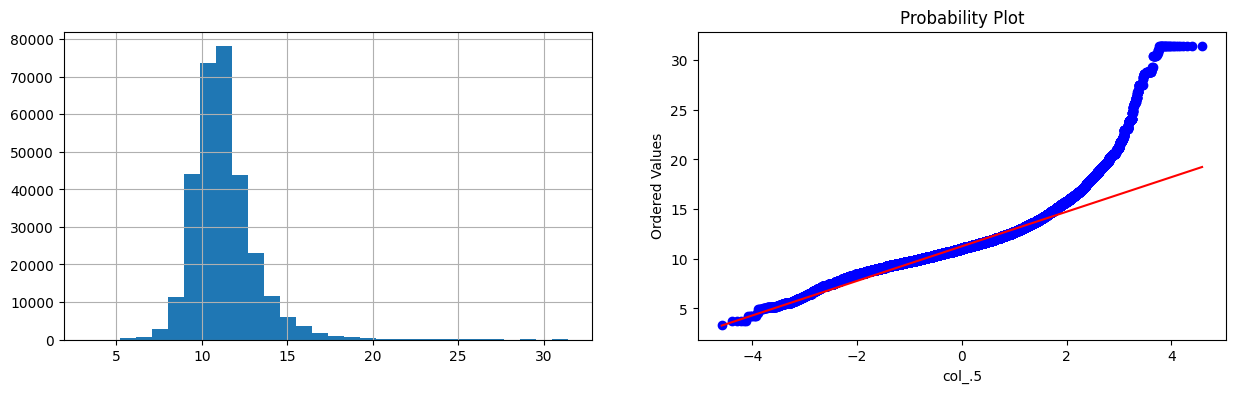

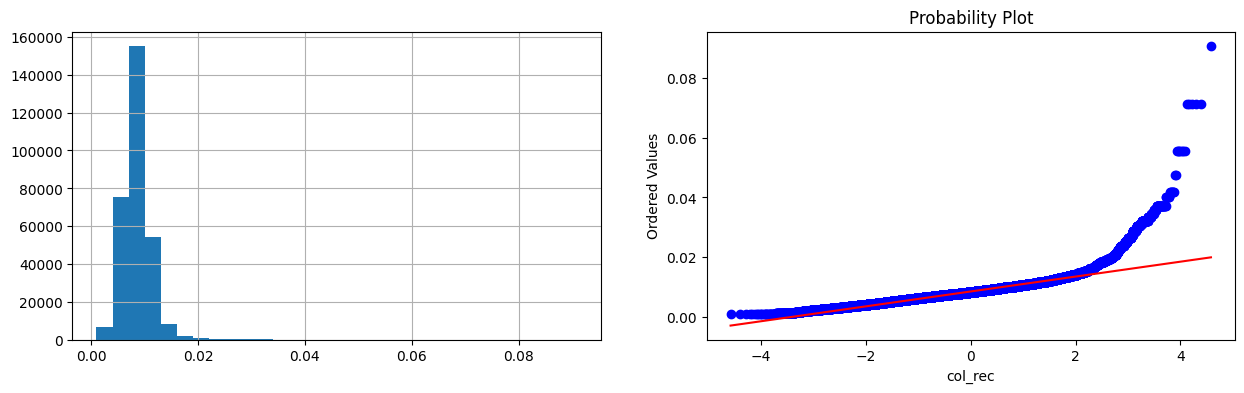

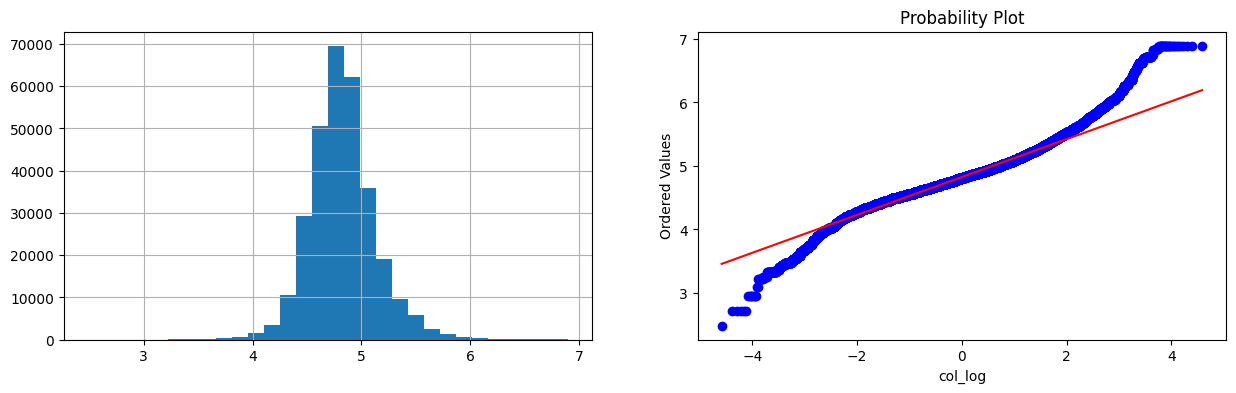

WBC
actual plot


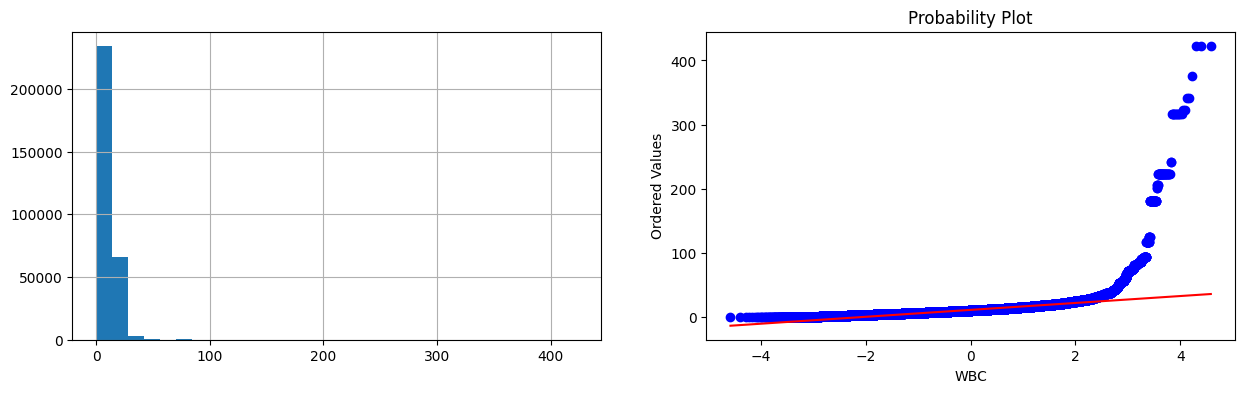

yeojohnson plot


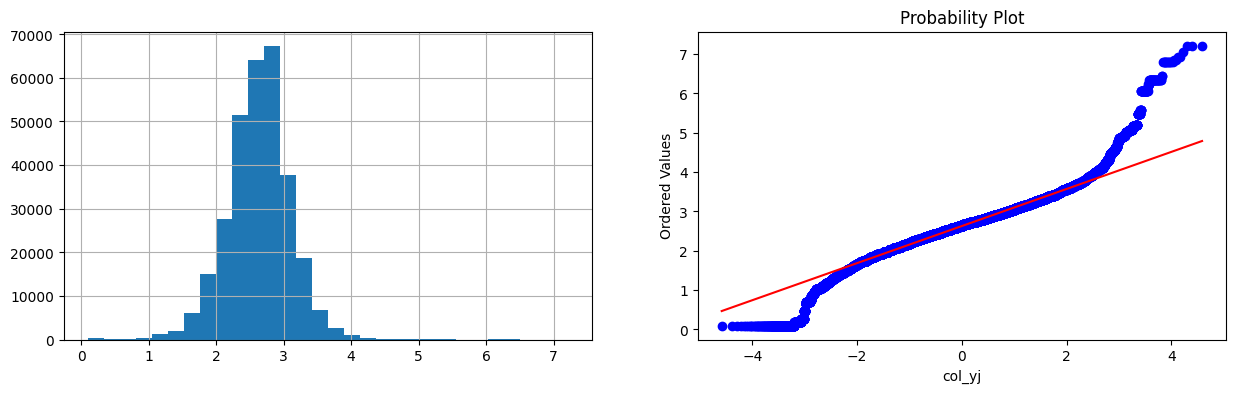

**1/1.5 plot


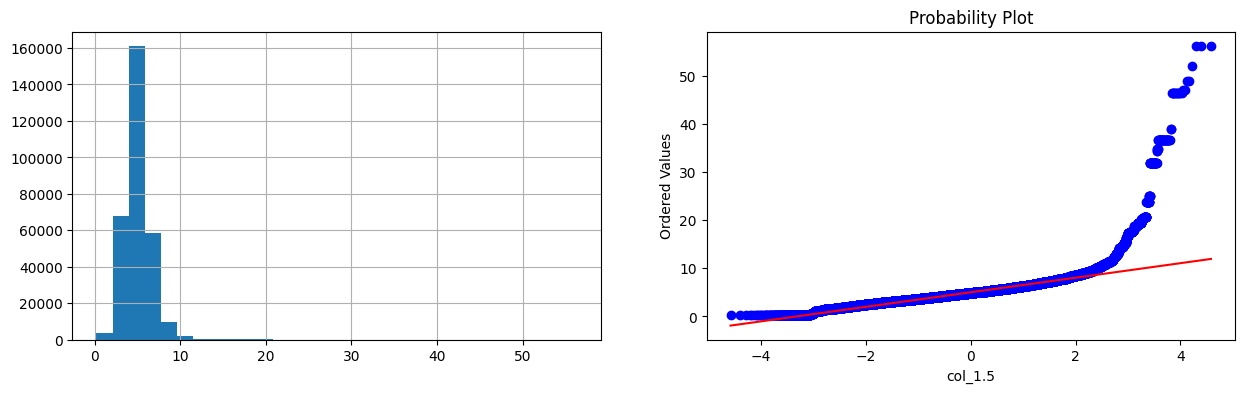

**.5 plot


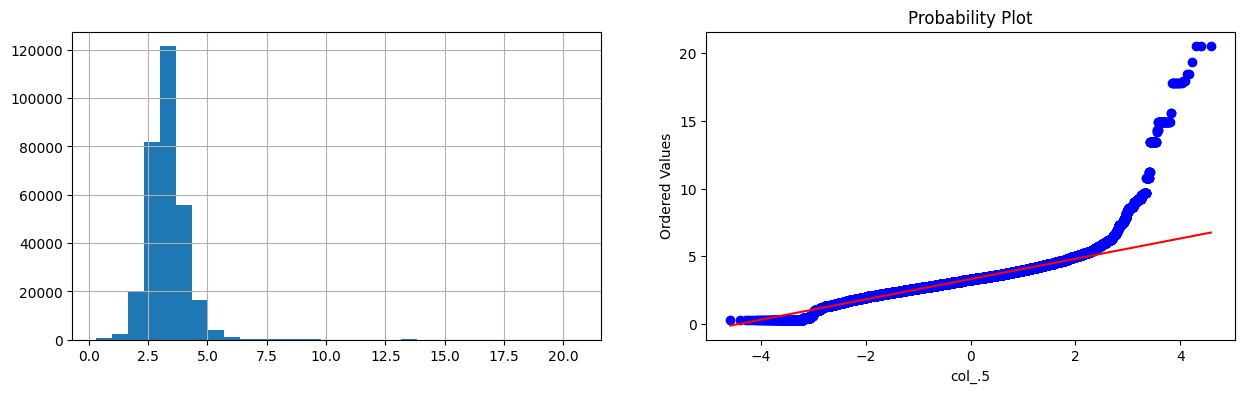

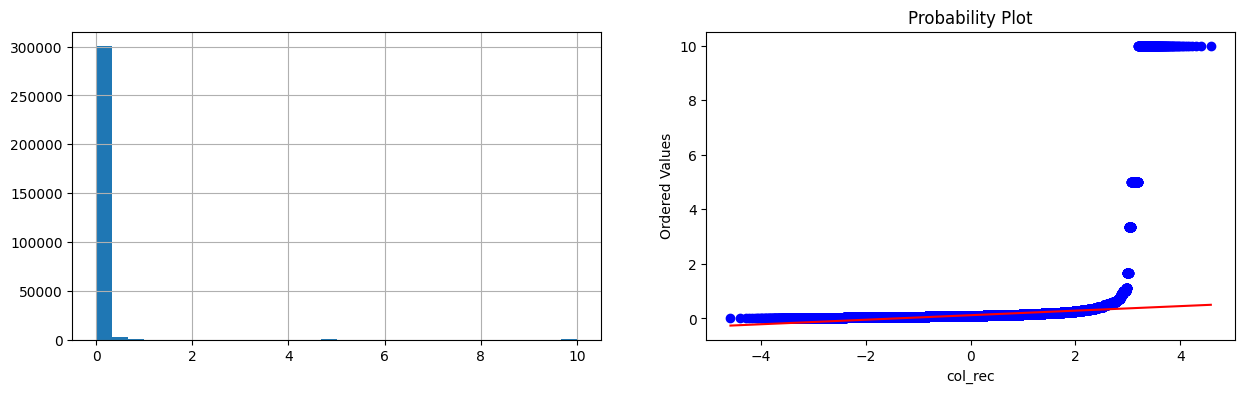

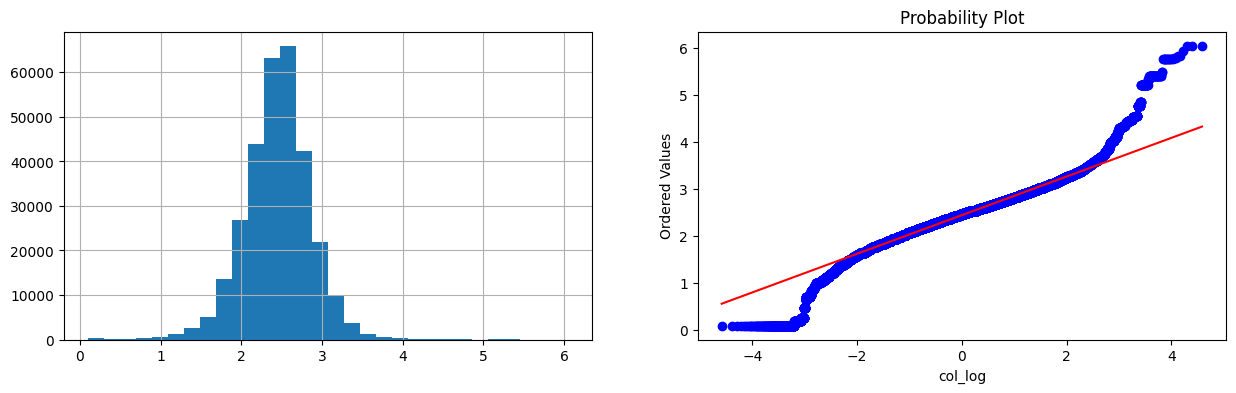

Platelets
actual plot


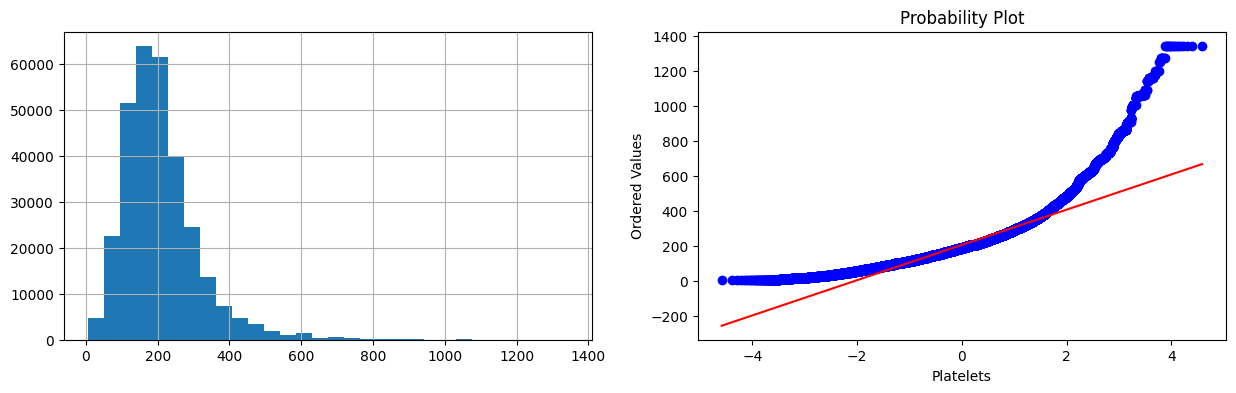

yeojohnson plot


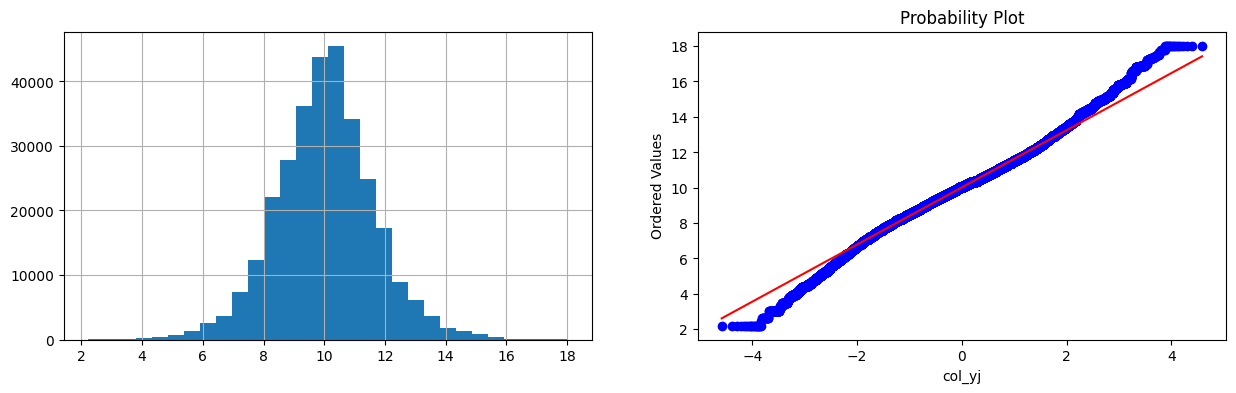

**1/1.5 plot


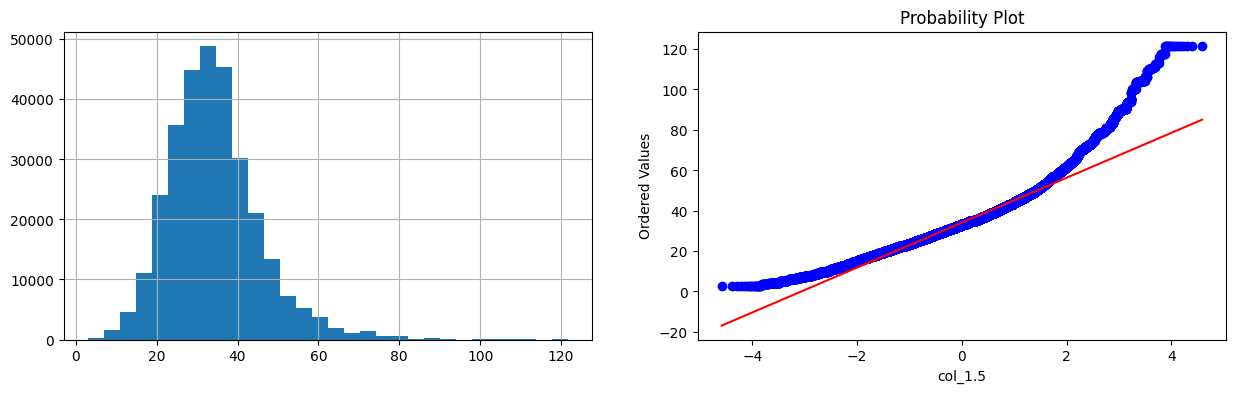

**.5 plot


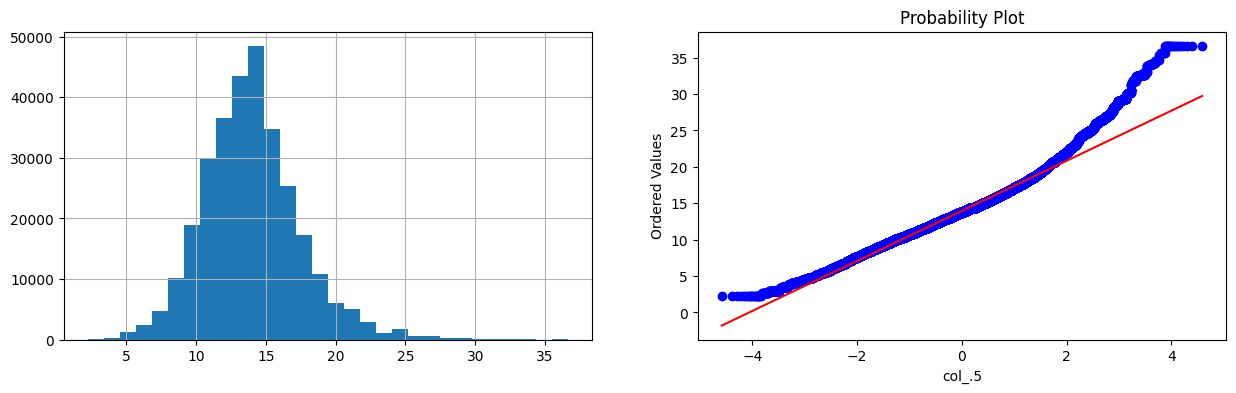

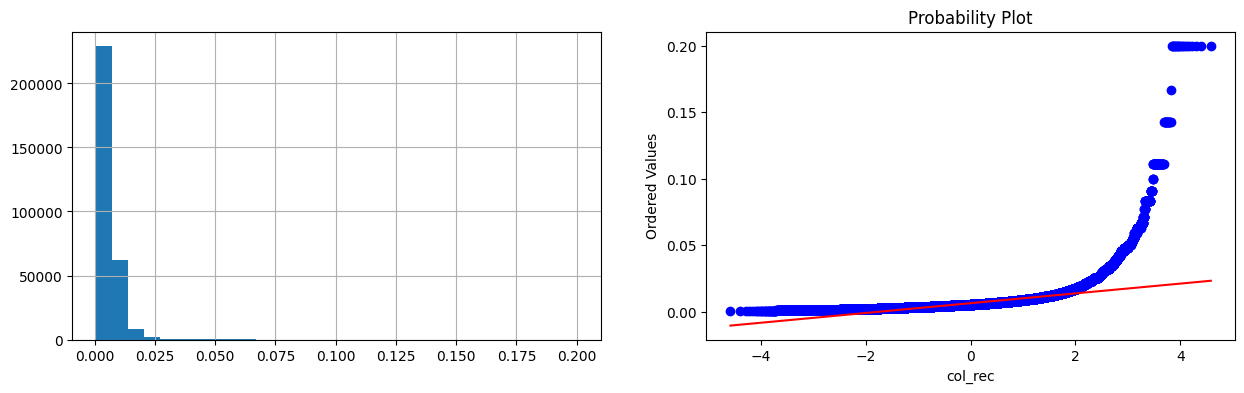

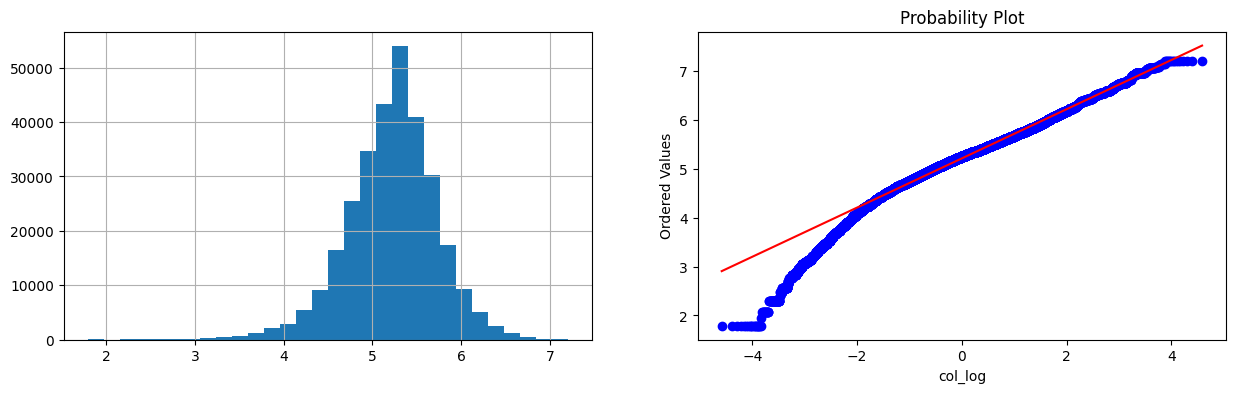

In [43]:
# try normal distribution
# Now we try to check the distribution of values present in different columns after application of various transformations

lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]

# Fill remaining NaN values with the mean of each column
for col in lst:
    if col in df_train_impute.columns:
        df_train_impute[col].fillna(df_train_impute[col].mean(), inplace=True)

for i in lst:
  print(i)
  try_gaussian(df_train_impute, i)

In [44]:
# after application of the above code, some redundant columns got added to the dataframe, which are removed through this line of code

df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

In [45]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp   BUN  Chloride  \
Patient_ID                                                                 
1.0        72964     0   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           72965     1   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           72966     2   89.0   99.0  36.11  86.00  22.0  14.0      85.0   
           72967     3   90.0   95.0  36.11  91.33  30.0  14.0      85.0   
           72968     4  103.0   88.5  36.11  91.33  24.5  14.0      85.0   

                  Creatinine  Glucose   Hct   Hgb  WBC  Platelets    Age  \
Patient_ID                                                                 
1.0        72964         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           72965         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           72966         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           72967         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           72968         0.7    193.0  37.2  12.5  5.7      317.0  83.14   

                  HospAdmTime  ICULOS  SepsisLabel   0.0    1.0  
Patient_ID                                                       
1.0        72964        -0.03     1.0          0.0  True  False  
           72965        -0.03     2.0          0.0  True  False  
           72966        -0.03     3.0          0.0  True  False  
           72967        -0.03     4.0          0.0  True  False  
           72968        -0.03     5.0          0.0  True  False

In [46]:
# by oserving different plots, it can be concluded that only log was somewhat effective and that too for MAP, BUN, Creatinine, Glucose, WBC & Plateletes
# therefore applying log transformations on the above columns

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [47]:
df_train_impute.head()

Hour     HR  O2Sat   Temp       MAP  Resp      BUN  \
Patient_ID                                                             
1.0        72964     0   97.0   95.0  36.11  4.335066  19.0  2.70805   
           72965     1   97.0   95.0  36.11  4.335066  19.0  2.70805   
           72966     2   89.0   99.0  36.11  4.465908  22.0  2.70805   
           72967     3   90.0   95.0  36.11  4.525369  30.0  2.70805   
           72968     4  103.0   88.5  36.11  4.525369  24.5  2.70805   

                  Chloride  Creatinine   Glucose   Hct   Hgb       WBC  \
Patient_ID                                                               
1.0        72964      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           72965      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           72966      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           72967      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           72968      85.0    0.530628  5.267858  37.2  12.5  1.902108   

                  Platelets    Age  HospAdmTime  ICULOS  SepsisLabel   0.0  \
Patient_ID                                                                   
1.0        72964   5.762051  83.14        -0.03     1.0          0.0  True   
           72965   5.762051  83.14        -0.03     2.0          0.0  True   
           72966   5.762051  83.14        -0.03     3.0          0.0  True   
           72967   5.762051  83.14        -0.03     4.0          0.0  True   
           72968   5.762051  83.14        -0.03     5.0          0.0  True   

                    1.0  
Patient_ID               
1.0        72964  False  
           72965  False  
           72966  False  
           72967  False  
           72968  False

In [48]:
# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                 
1.0        72964     0  0.715334 -0.686316 -1.112794 -0.171139  0.055400   
           72965     1  0.715334 -0.686316 -1.112794 -0.171139  0.055400   
           72966     2  0.247694  0.566584 -1.112794  0.534374  0.614607   
           72967     3  0.306149 -0.686316 -1.112794  0.854994  2.105825   
           72968     4  1.066063 -2.722279 -1.112794  0.854994  1.080613   

                       BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                             
1.0        72964 -0.425596 -3.678746   -0.563764  1.461788  1.197136   
           72965 -0.425596 -3.678746   -0.563764  1.461788  1.197136   
           72966 -0.425596 -3.678746   -0.563764  1.461788  1.197136   
           72967 -0.425596 -3.678746   -0.563764  1.461788  1.197136   
           72968 -0.425596 -3.678746   -0.563764  1.461788  1.197136   

                       Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
Patient_ID                                                                    
1.0        72964  1.083153 -1.302285    1.07504  83.14        -0.03     1.0   
           72965  1.083153 -1.302285    1.07504  83.14        -0.03     2.0   
           72966  1.083153 -1.302285    1.07504  83.14        -0.03     3.0   
           72967  1.083153 -1.302285    1.07504  83.14        -0.03     4.0   
           72968  1.083153 -1.302285    1.07504  83.14        -0.03     5.0   

                  SepsisLabel   0.0    1.0  
Patient_ID                                  
1.0        72964          0.0  True  False  
           72965          0.0  True  False  
           72966          0.0  True  False  
           72967          0.0  True  False  
           72968          0.0  True  False

In [49]:
df_train_impute = df_train_impute.dropna()

In [50]:
null_values = df_train_impute.isnull().mean()*100
null_values

Hour           0.0
HR             0.0
O2Sat          0.0
Temp           0.0
MAP            0.0
Resp           0.0
BUN            0.0
Chloride       0.0
Creatinine     0.0
Glucose        0.0
Hct            0.0
Hgb            0.0
WBC            0.0
Platelets      0.0
Age            0.0
HospAdmTime    0.0
ICULOS         0.0
SepsisLabel    0.0
0.0            0.0
1.0            0.0
dtype: float64

Model Building

In [51]:
# this function will transform the dataframe (for final testing) in the compatible
# format for the input of the model
# this will make it easier to get the dataframe ready in a single go for prediction

def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  df.columns = df.columns.astype(str) # Convert column names to strings
  return df

In [52]:
# this fucntion calculates different evaluation parameters of a model

def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [53]:
# checking the distribution of data points between the two classes

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 6149
while number of sepsis label 0 is 291724


So, this shows a clear imbalance between sepsis label 1 and label 0, to deal with this, we did undersampling.

In [54]:
# Undersampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

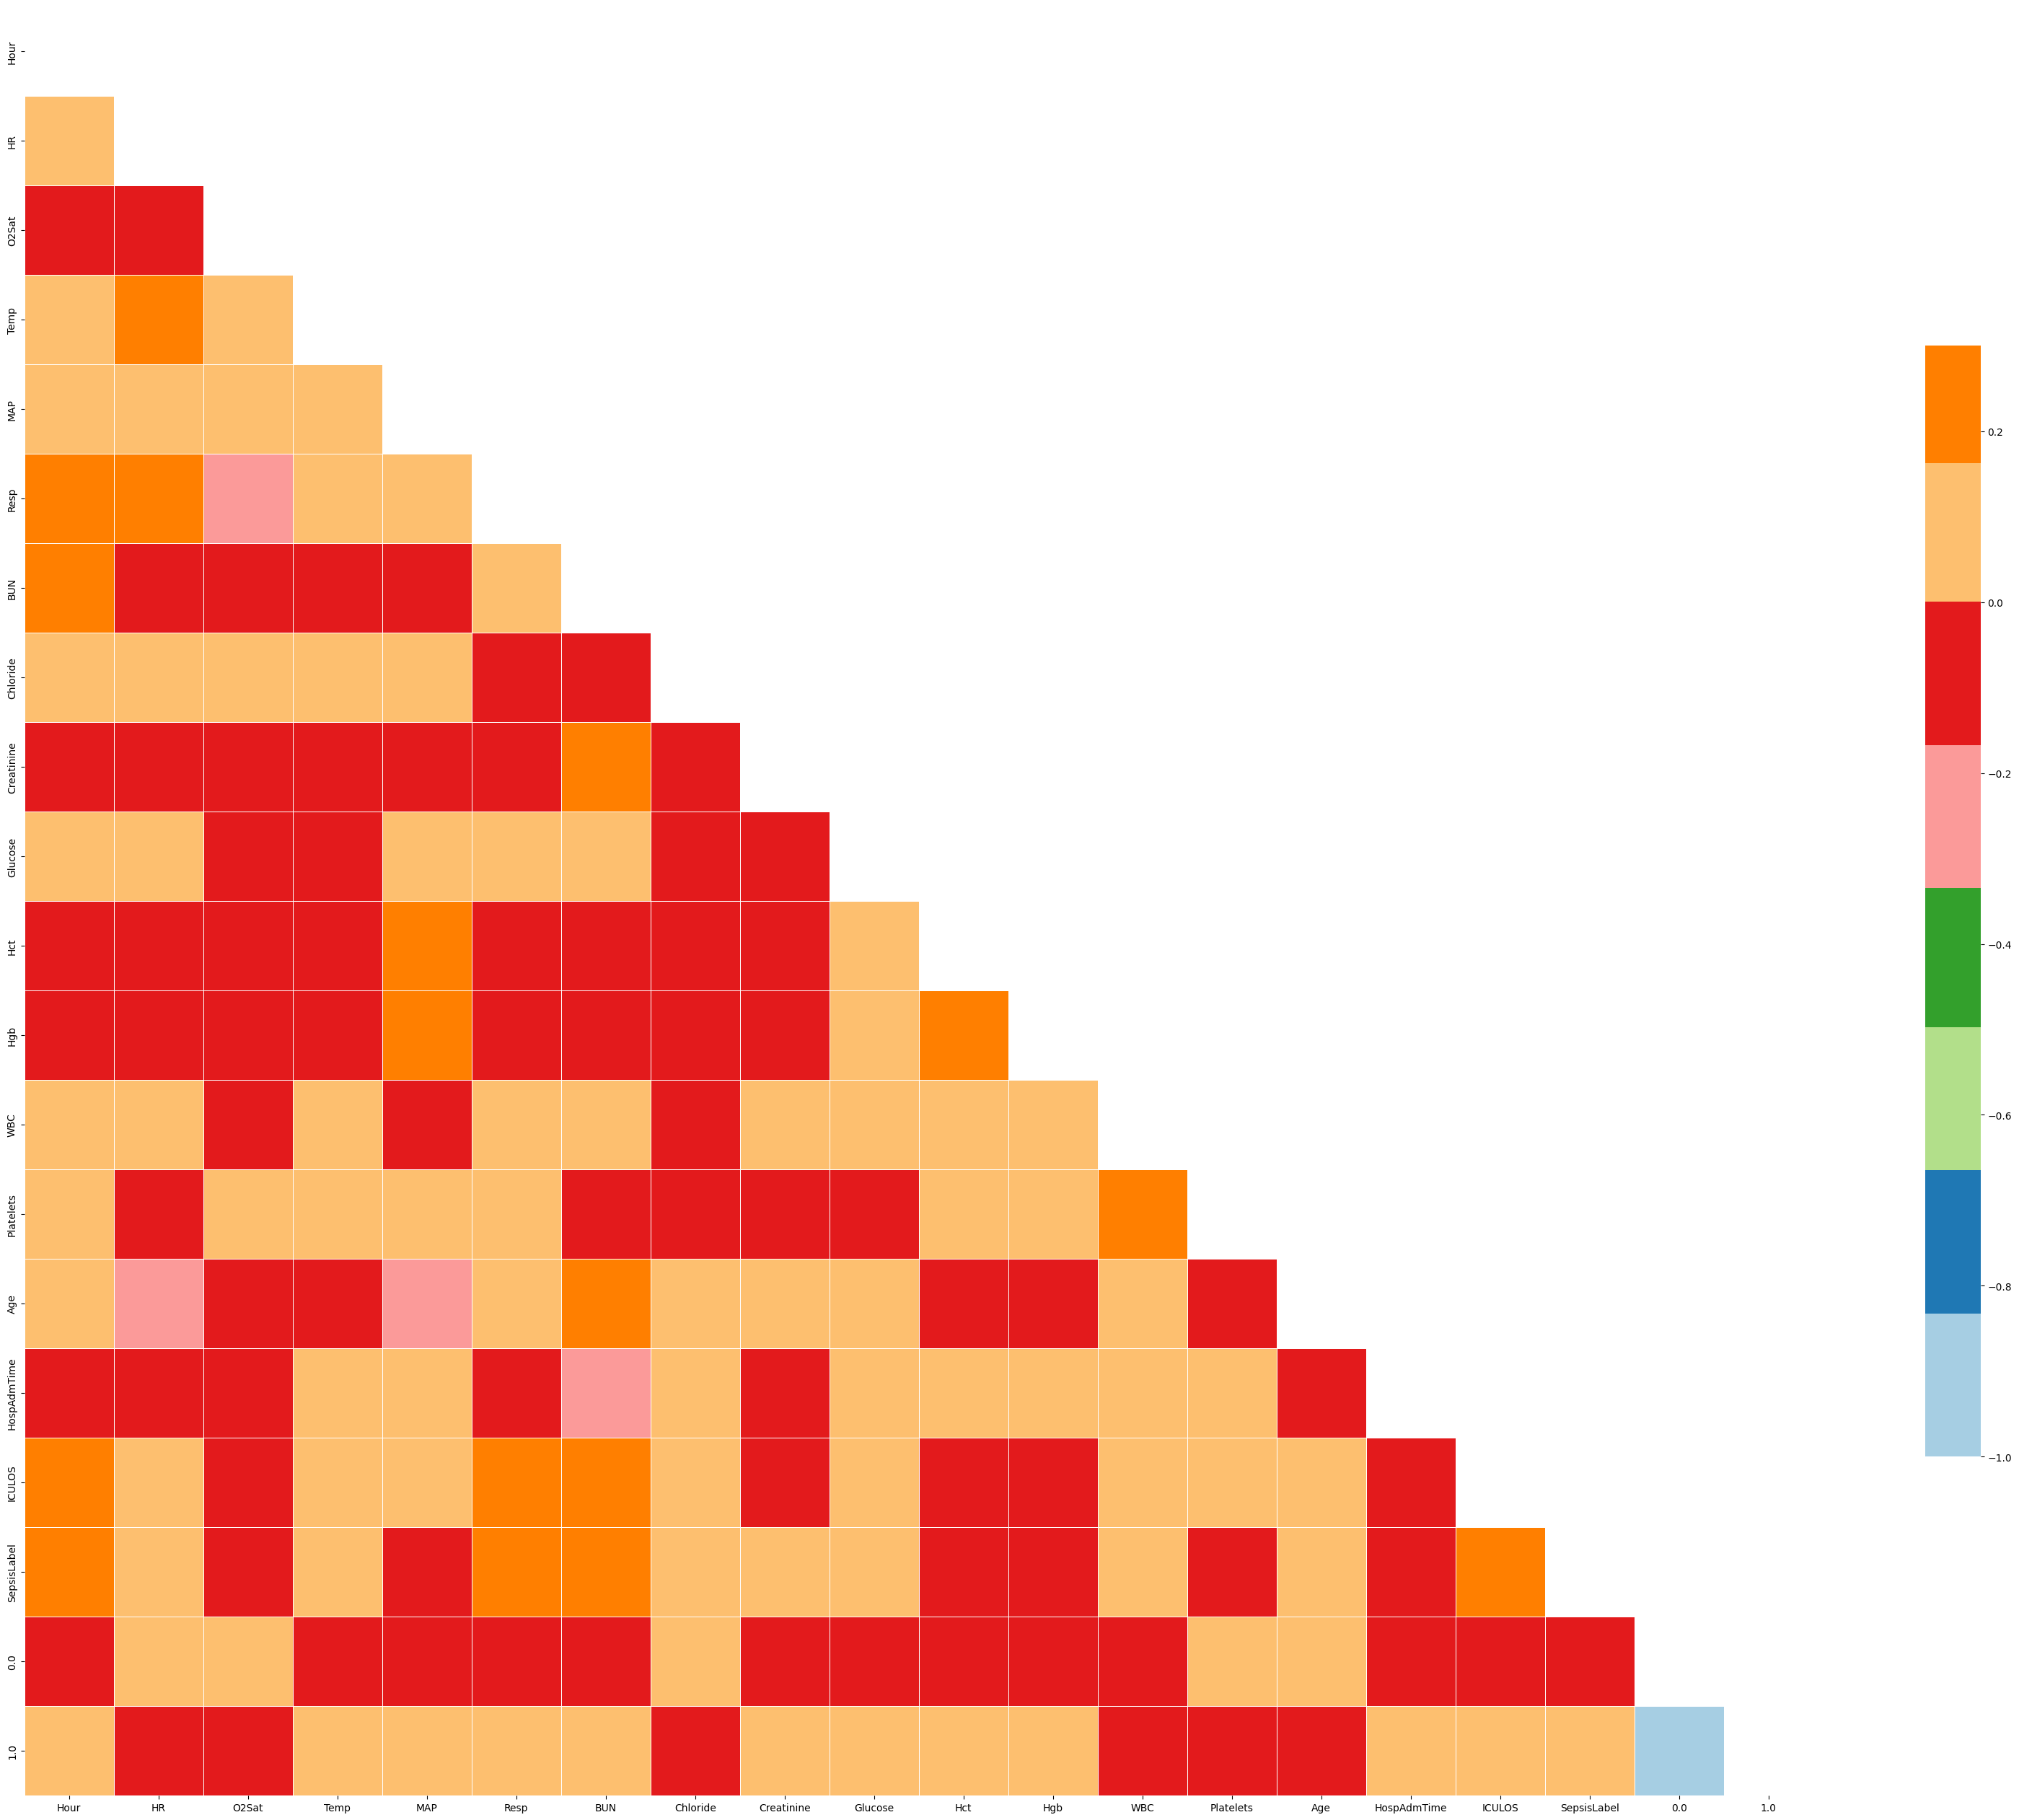

In [55]:
corr_matrix(df_train_impute)

Random Forest

In [56]:
# train test split for the imputed output
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [57]:
# random forest classifier
# random forest classifier was tested on different hyper parameters and it gave the best results with number of estimators as 300

# model = RandomForestClassifier(n_estimators=100, random_state=0)
# model = RandomForestClassifier(n_estimators=200, random_state=0)
model = RandomForestClassifier(n_estimators=300, random_state=0)

# Reset index and convert column names to strings
X_train = X_train.reset_index().set_index('Patient_ID')
X_test = X_test.reset_index().set_index('Patient_ID')

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

Accuracy: 0.9701897018970189
Precision: 0.9375951293759512
Recall: 0.9777777777777777
F1 Score: 0.9572649572649573
AUC-ROC: 0.9720164609053499
Mean Absolute Error: 0.02981029810298103
Root Mean Squared Error: 0.17265659009427073


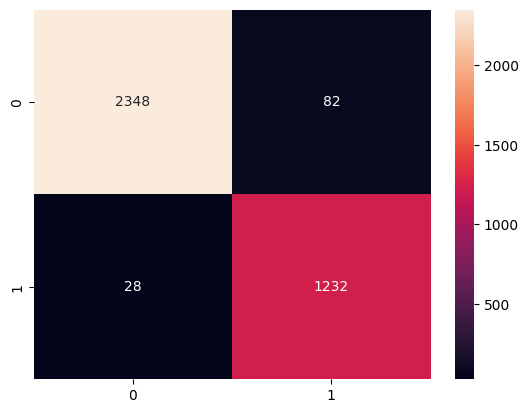

In [58]:
evaluate_model(y_test,rcf_predictions)

# Naive Bayes Classifier


Accuracy: 0.7493224932249323
Precision: 0.7933450087565674
Recall: 0.3595238095238095
F1 Score: 0.4948115783724741
AUC-ROC: 0.6554820693709582
Mean Absolute Error: 0.2506775067750677
Root Mean Squared Error: 0.5006770483805582


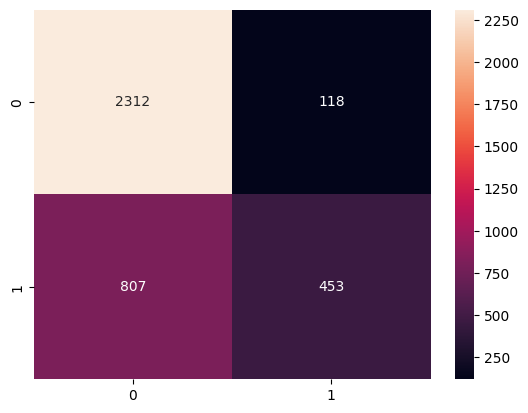

In [59]:
# NBC performed worse than random forest on each and every aspect of the evaluation metrics

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
nbc_predictions = model.predict(X_test)
evaluate_model(y_test,nbc_predictions)

# KNN Classifier


Accuracy: 0.8346883468834688
Precision: 0.696969696969697
Recall: 0.9126984126984127
F1 Score: 0.7903780068728522
AUC-ROC: 0.8534685479129923
Mean Absolute Error: 0.16531165311653118
Root Mean Squared Error: 0.4065853577252029


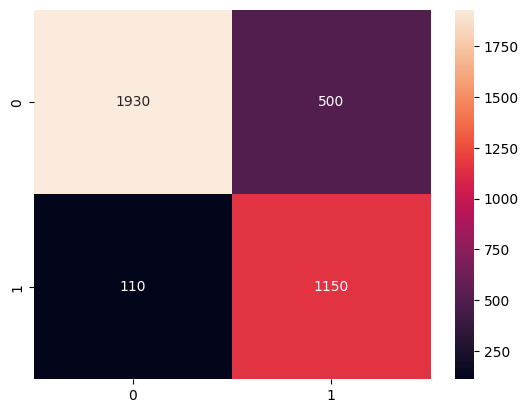

In [60]:
# KNN was tested on different values of k

from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=8)
# model = KNeighborsClassifier(n_neighbors=5)
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
knn_predictions = model.predict(X_test)
evaluate_model(y_test,knn_predictions)

# Logistic Regression


Accuracy: 0.753929539295393
Precision: 0.802405498281787
Recall: 0.37063492063492065
F1 Score: 0.507057546145494
AUC-ROC: 0.6616549088771311
Mean Absolute Error: 0.24607046070460706
Root Mean Squared Error: 0.4960548968658681


/Users/yash/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


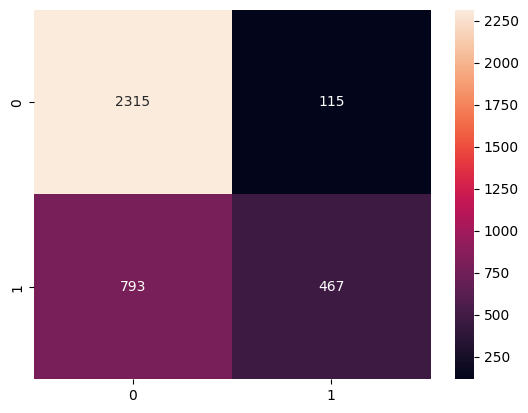

In [61]:

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)
evaluate_model(y_test,lr_predictions)



```
# XGBoost
```



Accuracy: 0.926829268292683
Precision: 0.8972712680577849
Recall: 0.8873015873015873
F1 Score: 0.8922585794094174
AUC-ROC: 0.9173133450911227
Mean Absolute Error: 0.07317073170731707
Root Mean Squared Error: 0.2705008904002297


/Users/yash/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [23:32:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


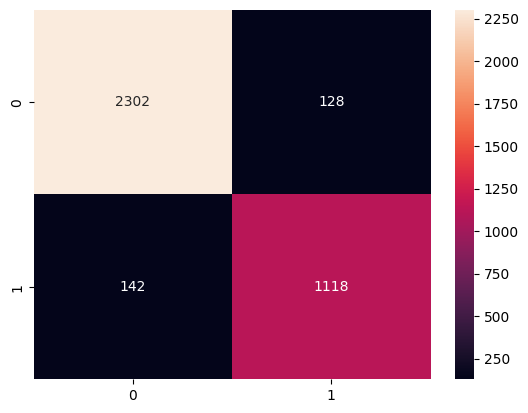

In [62]:
# XGBoost was run for different combinations of hyperparameters, but overall random forest classifier performed the best in terms of F1 score and other metrics

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:logistic'}  # error evaluation for binary classification
num_round = 100
bst = xgb.train(param, dtrain, num_round)
xgb_predictions = bst.predict(dtest)
prediction = []
for i in xgb_predictions:
  if i<0.5:
    prediction.append(0)
  else:
    prediction.append(1)
evaluate_model(y_test,prediction)

# Testing on the data of the other hospital

/var/folders/nh/kck6hr314vv_9n1v0l6b_2j80000gn/T/ipykernel_84145/696764516.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())


Accuracy: 0.9312584377808157
Precision: 0.10704533042053523
Recall: 0.3387340678332253
F1 Score: 0.16268091508014731
AUC-ROC: 0.640954240339468
Mean Absolute Error: 0.06874156221918426
Root Mean Squared Error: 0.26218612133212593


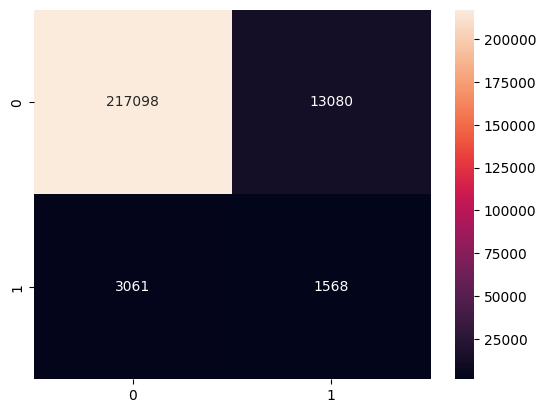

In [63]:
# testing on the other hospital data

df = get_data_ready(df_test)
X = df.drop('SepsisLabel', axis=1)
y = df['SepsisLabel']

# Apply the same index resetting and setting as done for training data
X = X.reset_index().set_index('Patient_ID')
X.columns = X.columns.astype(str) # Ensure column names are strings

rcf_predictions = model.predict(X)
evaluate_model(y,rcf_predictions)

In [64]:
df_train_impute.to_pickle('df_train_impute.pkl')